In [209]:
library(ggplot2)
library(gridExtra)
library(purrr)
library(gridExtra)


In [210]:
# read in BIC cutoffs
BIC_cuttoffs = readRDS("/Users/shayecarver/condPCA/ASHG/Morabito/BIC/BIC_elbow_cutoffs_df.rds")
BIC_cuttoffs

Dataframe,BIC,Elbow
<glue>,<int>,<dbl>
RNA_Standard_PCA,74,16
RNA_Conditional_PCA,76,12
RNA_ODC,41,9
RNA_MG,14,5
RNA_OPC,10,9
RNA_INH,30,16
RNA_EX,26,17
RNA_ASC,15,8
RNA_PER.END,4,8


In [211]:
# ATAC
stand = read.csv("~/Downloads/ATAC/Morabito_ATAC_Standard_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_Standard_PCA"),]$BIC]
cond = read.csv("~/Downloads/ATAC/Morabito_ATAC_Conditional_Celltype_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_Conditional_PCA"),]$BIC]
ASC = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_ASC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_ASC"),]$BIC]
EX = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_EX_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_EX"),]$BIC]
INH = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_INH_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_INH"),]$BIC]
MG = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_MG_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_MG"),]$BIC]
ODC = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_ODC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_ODC"),]$BIC]
OPC = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_OPC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_OPC"),]$BIC]
PER.END = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_PER.END_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_PER.END"),]$BIC]


In [212]:
dim(stand)
dim(cond)
dim(ASC)
dim(EX)
dim(INH)
dim(MG)
dim(ODC)
dim(OPC)
dim(PER.END)

[1] 3000   52

[1] 3000   48

[1] 3000   24

[1] 3000   26

[1] 3000   10

[1] 3000   23

[1] 3000   35

[1] 3000    4

[1] 3000    3

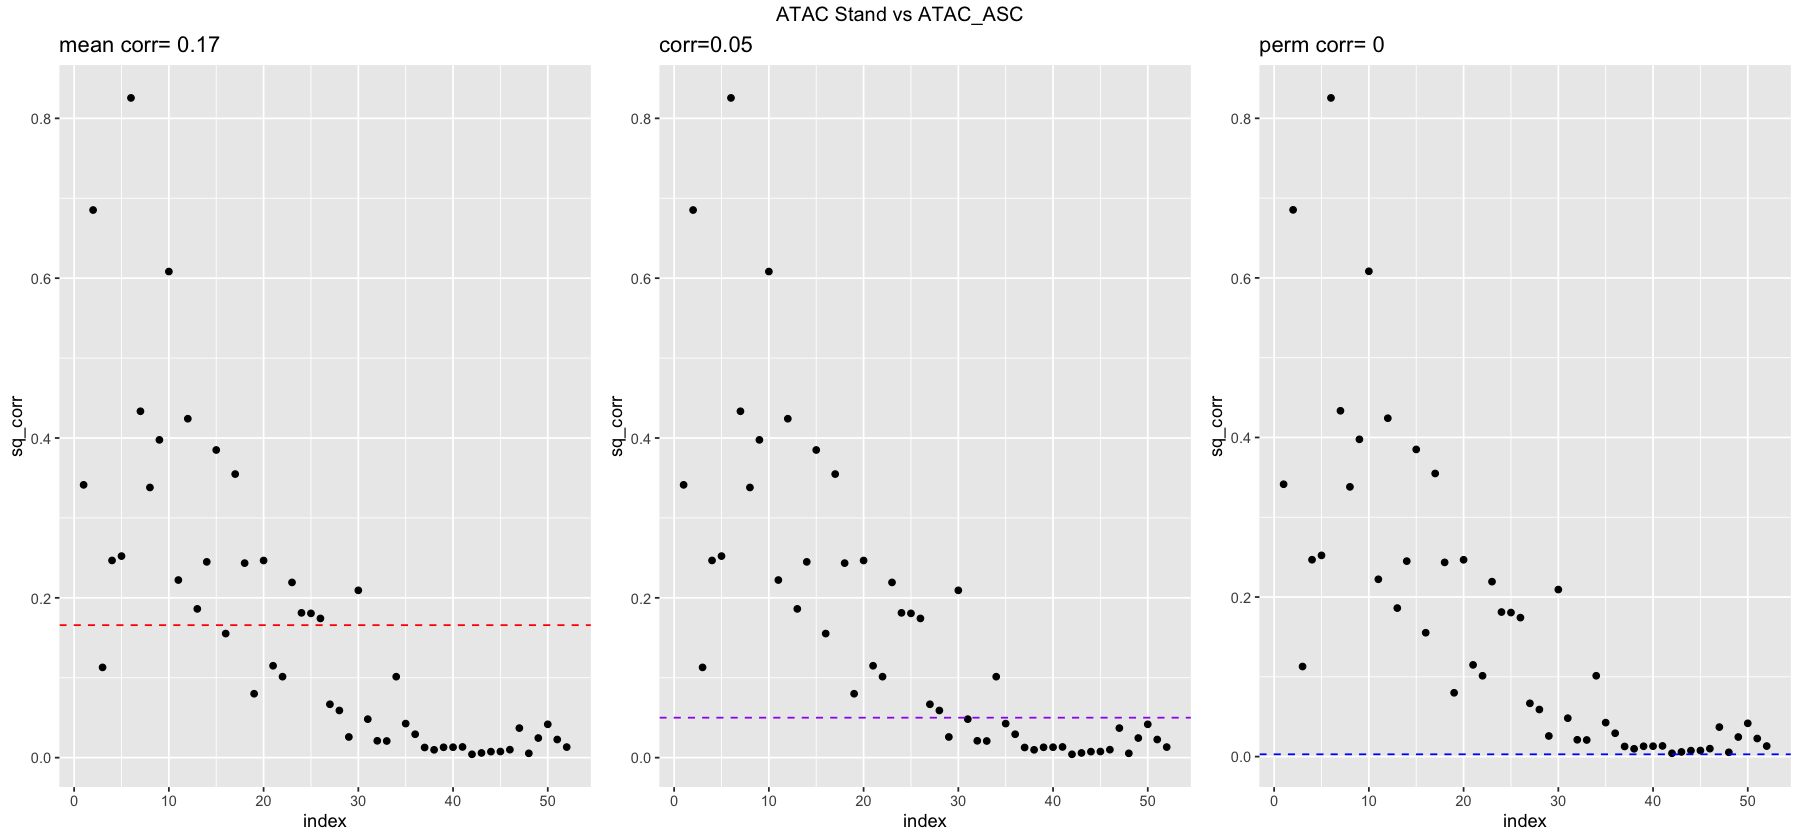

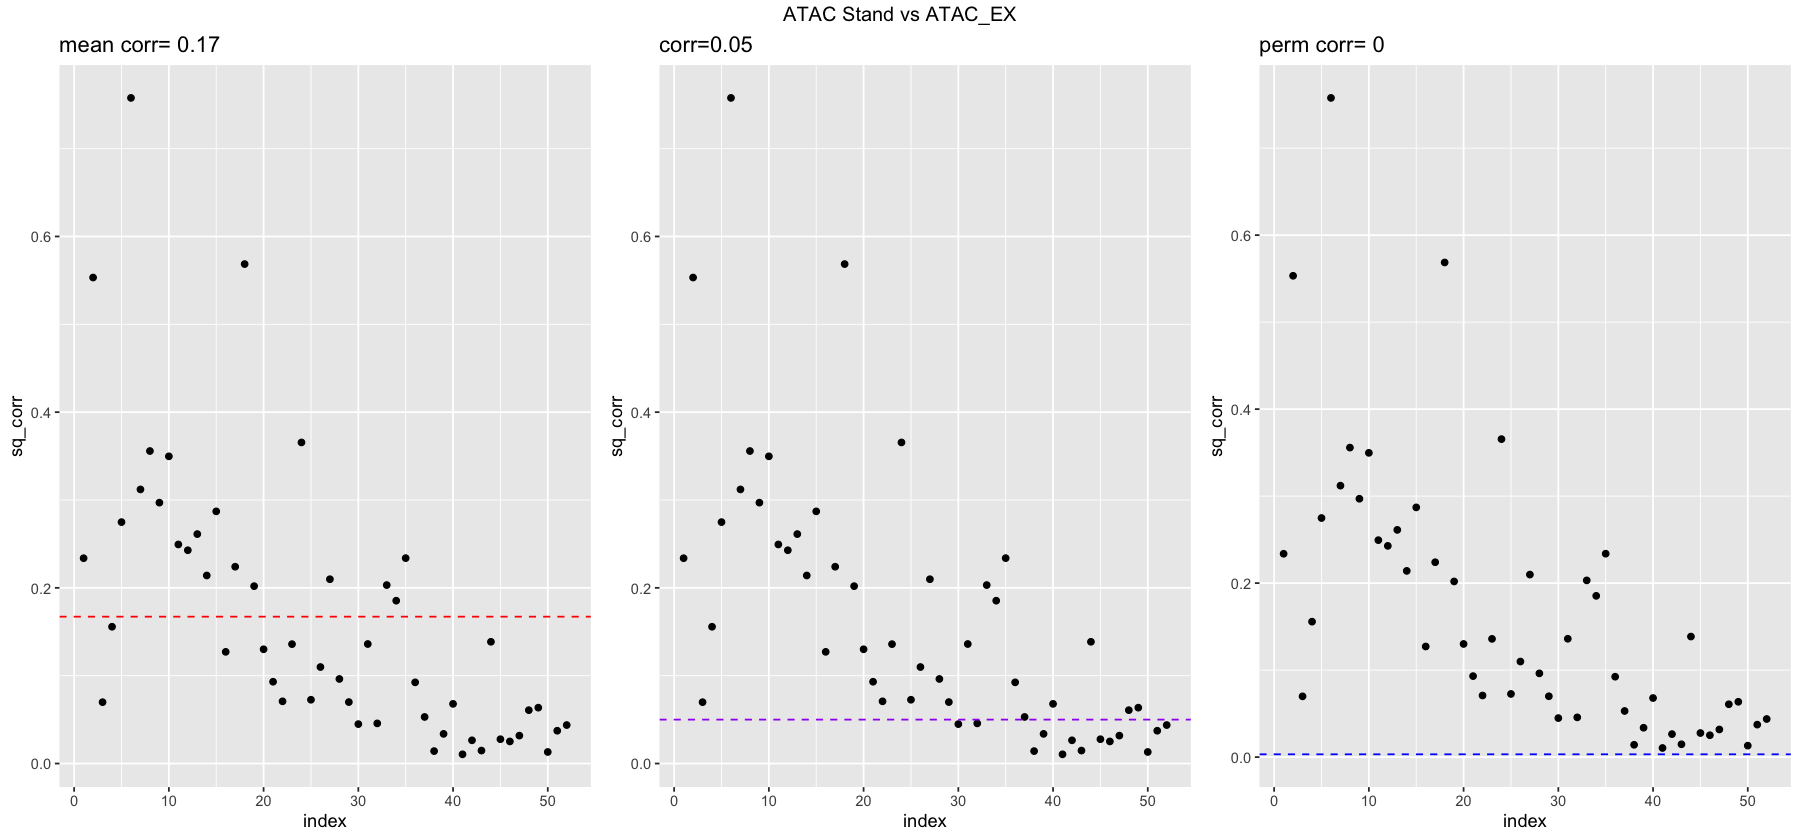

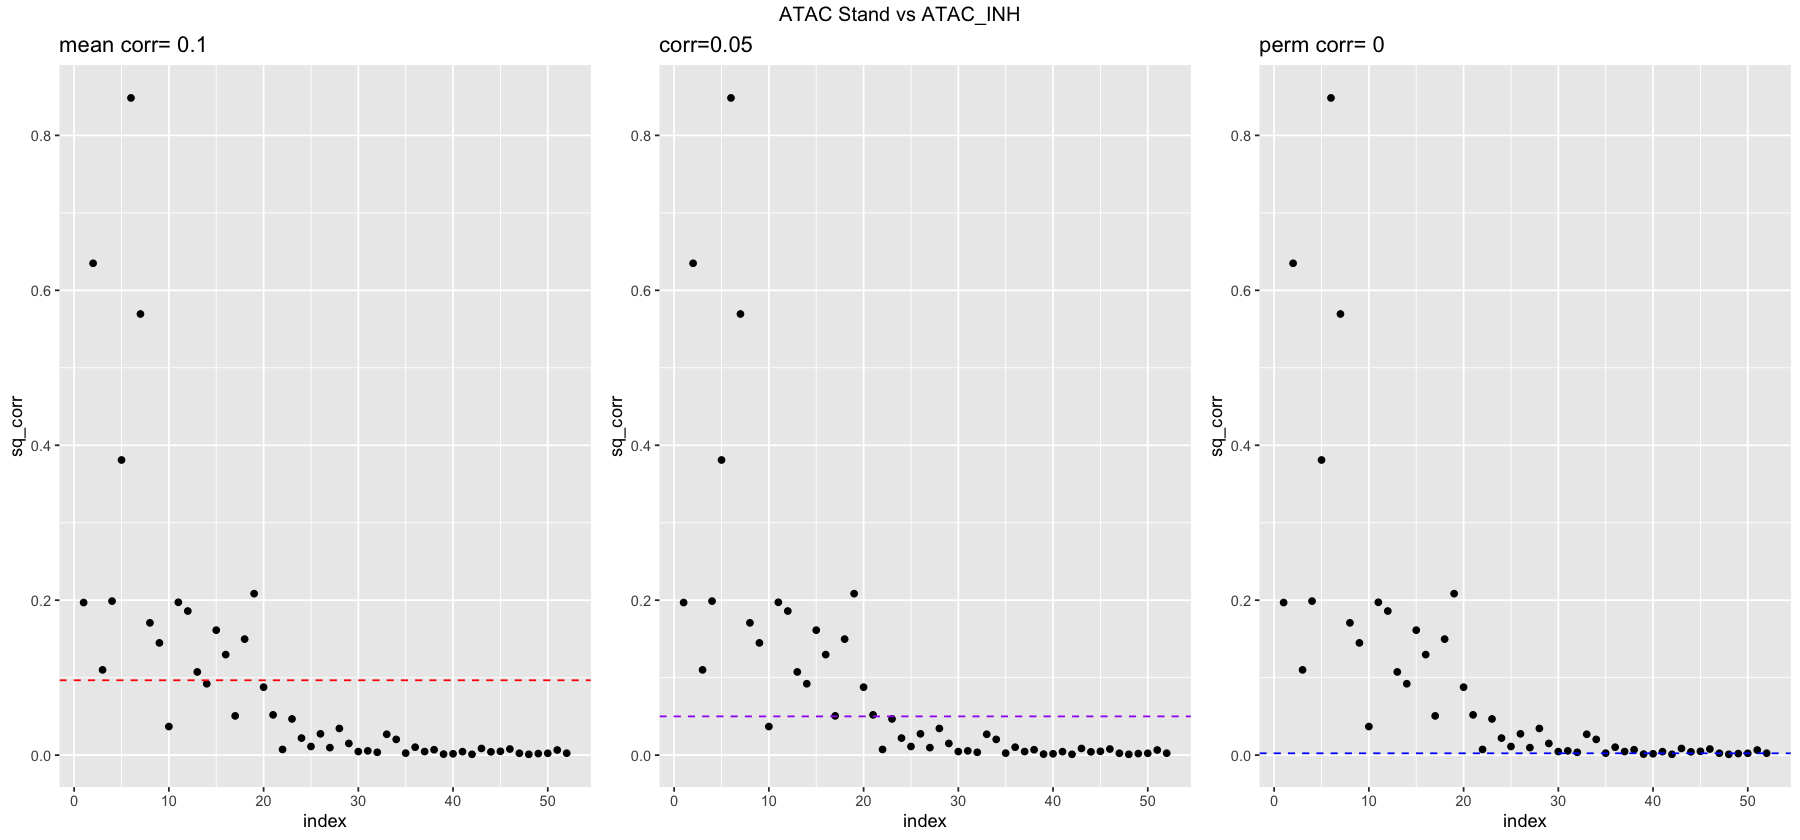

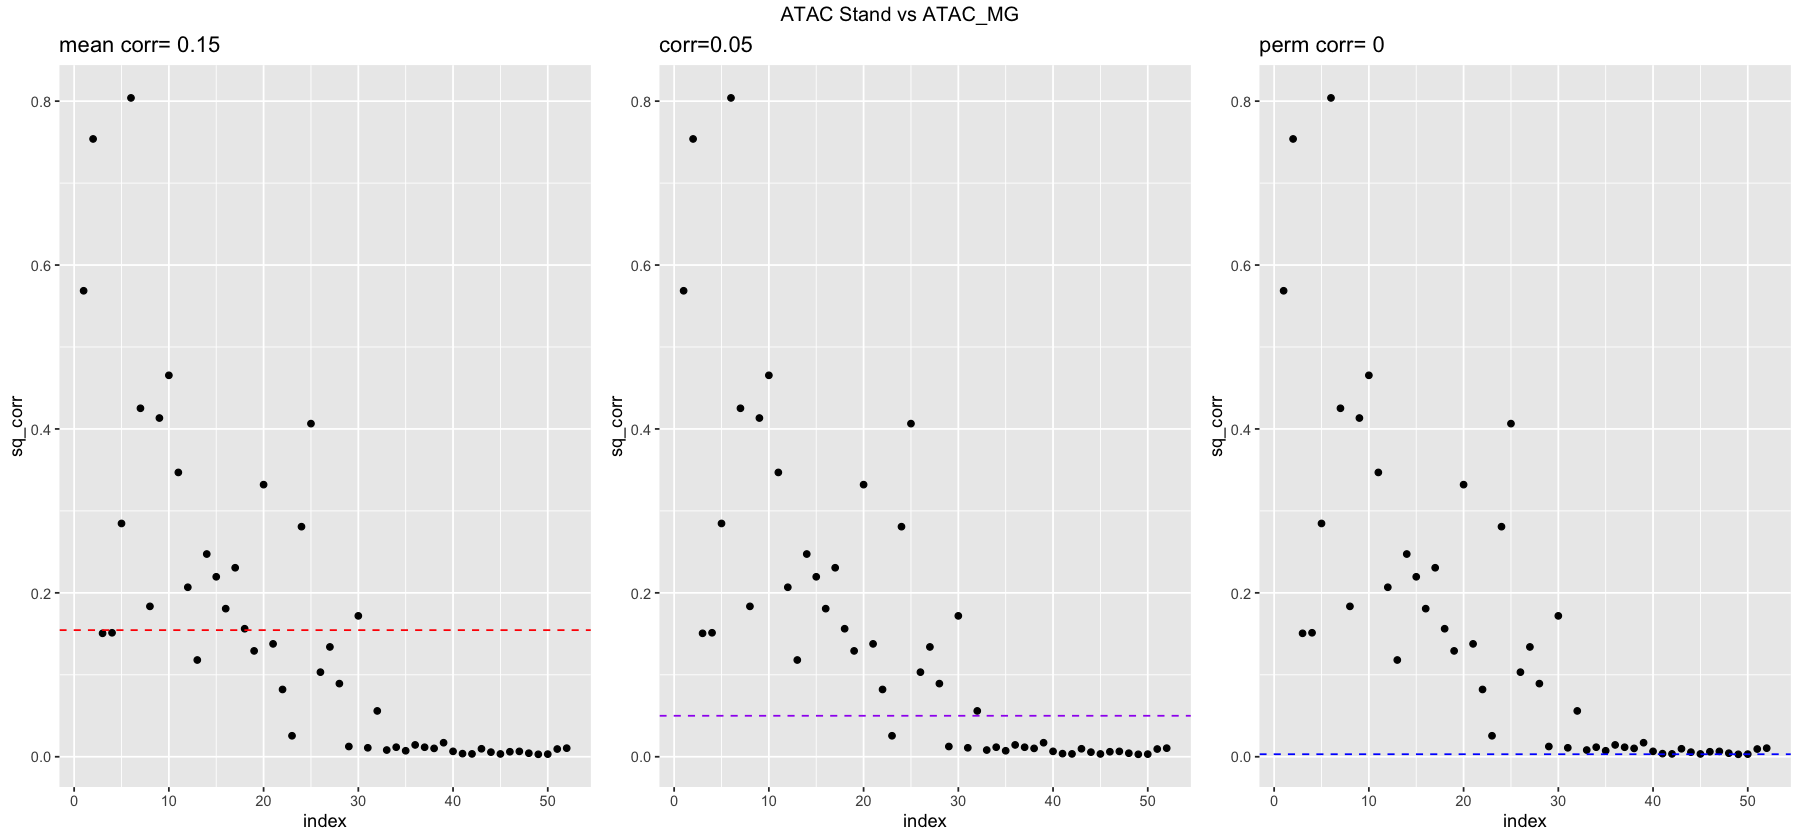

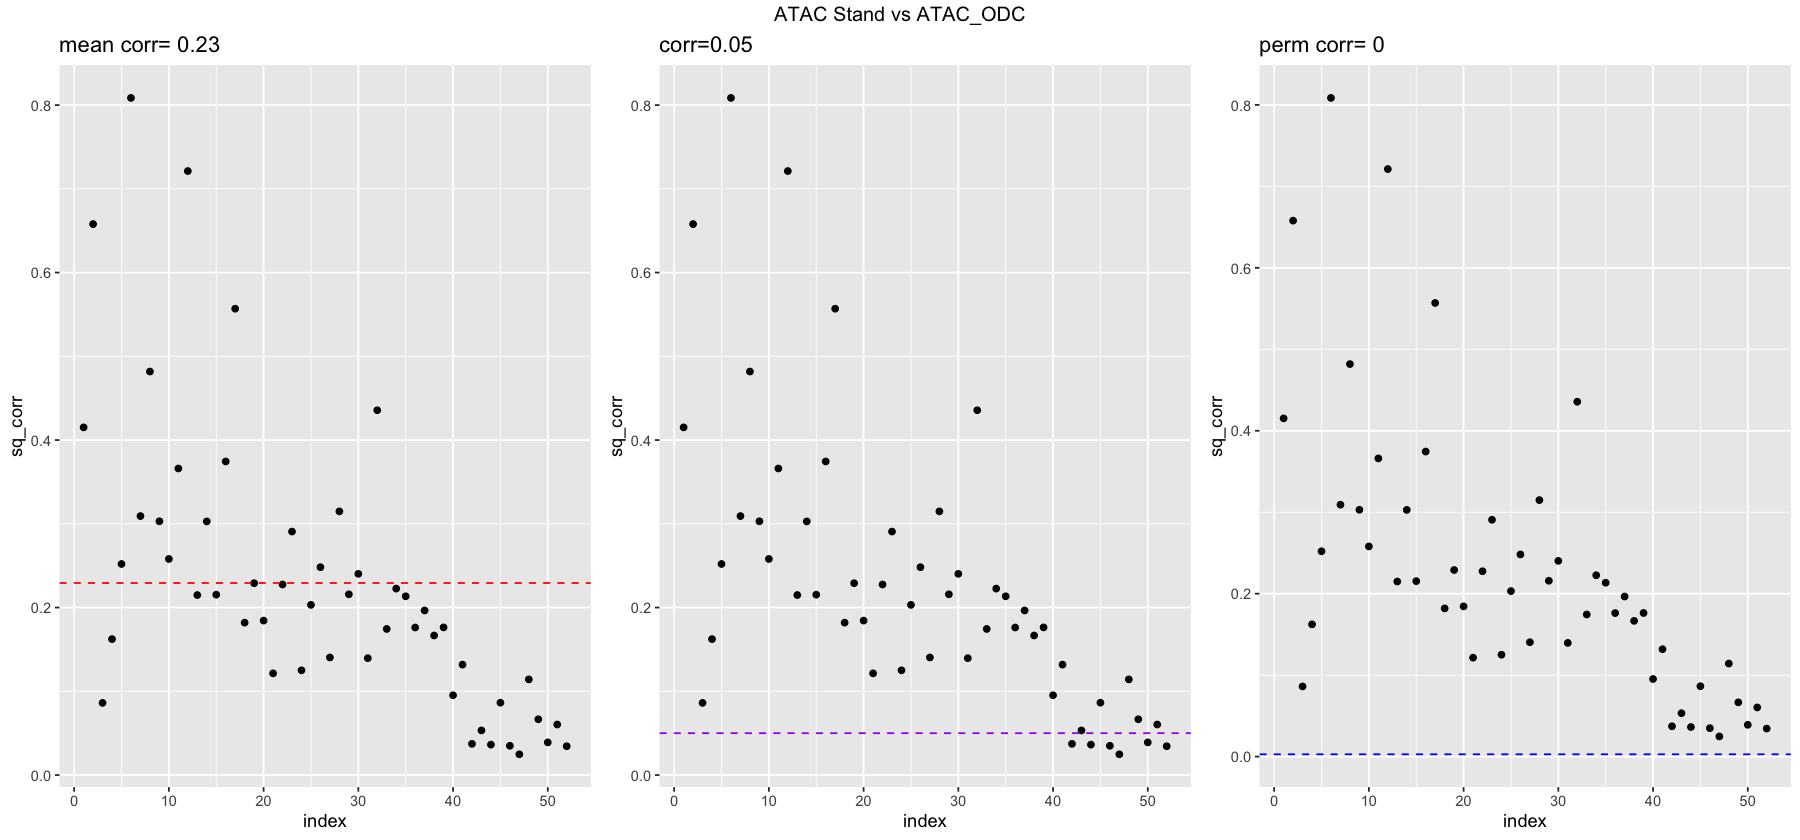

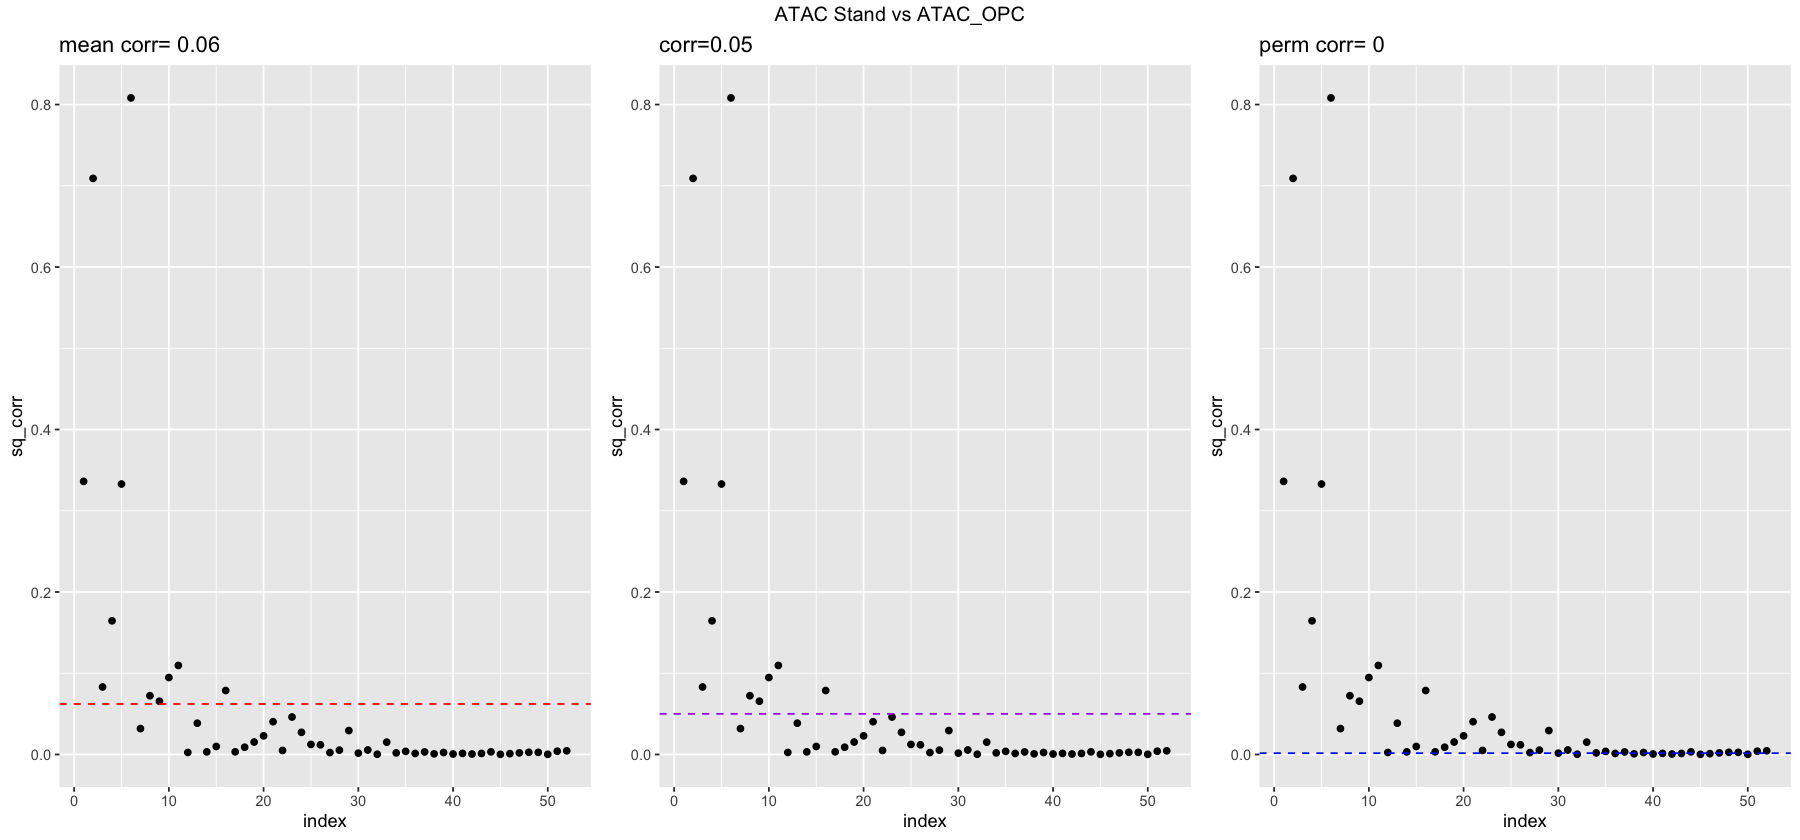

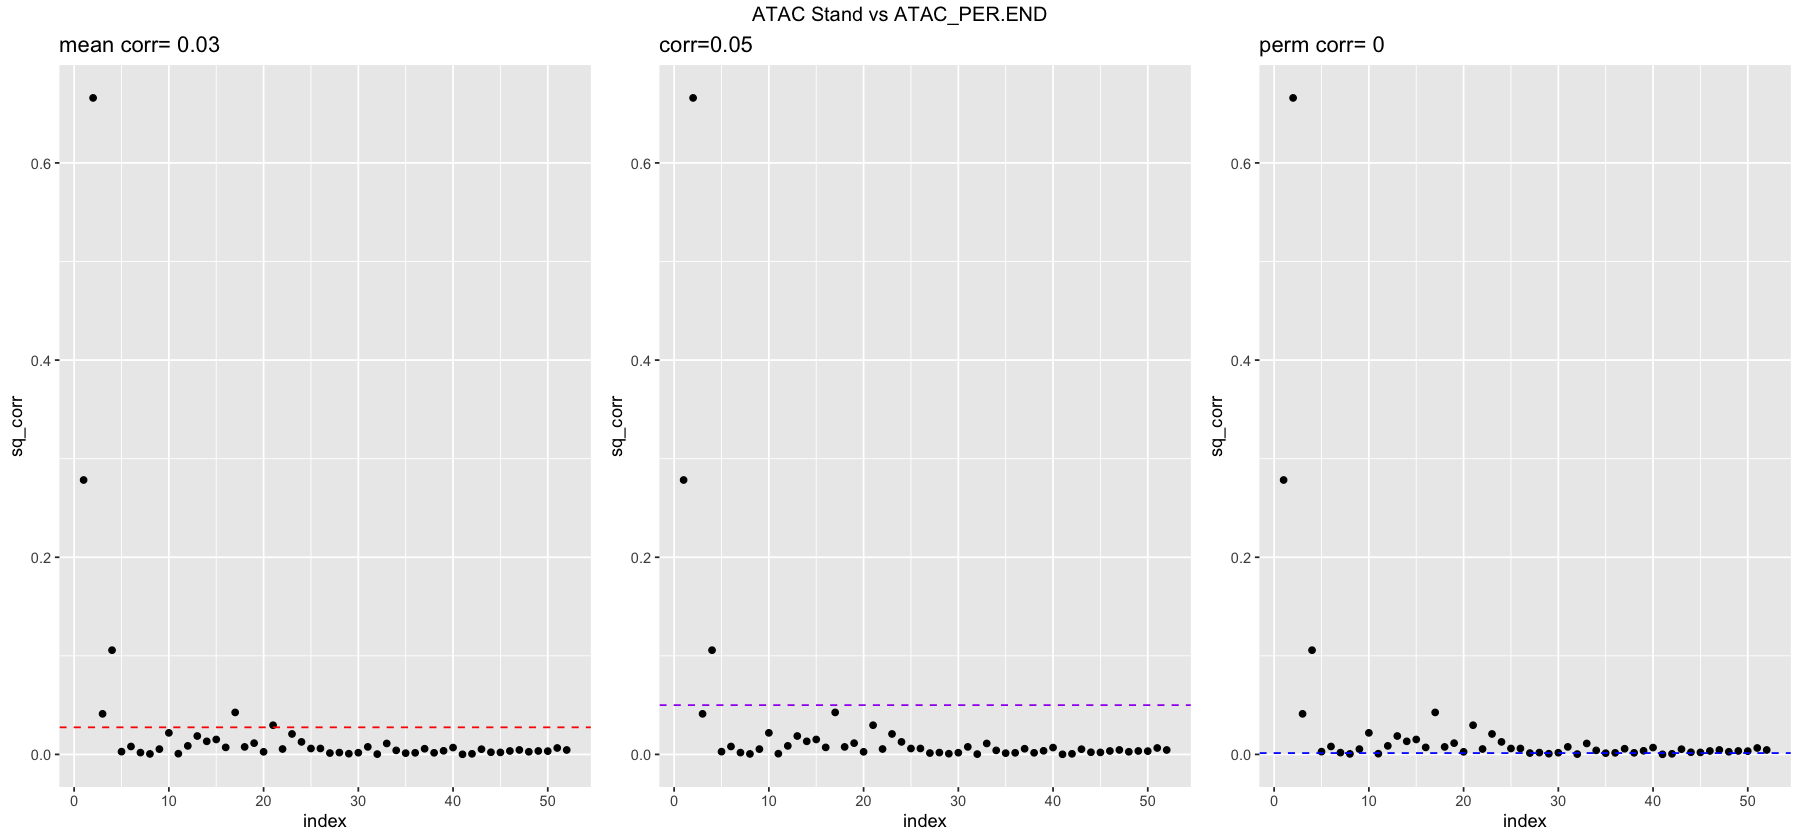

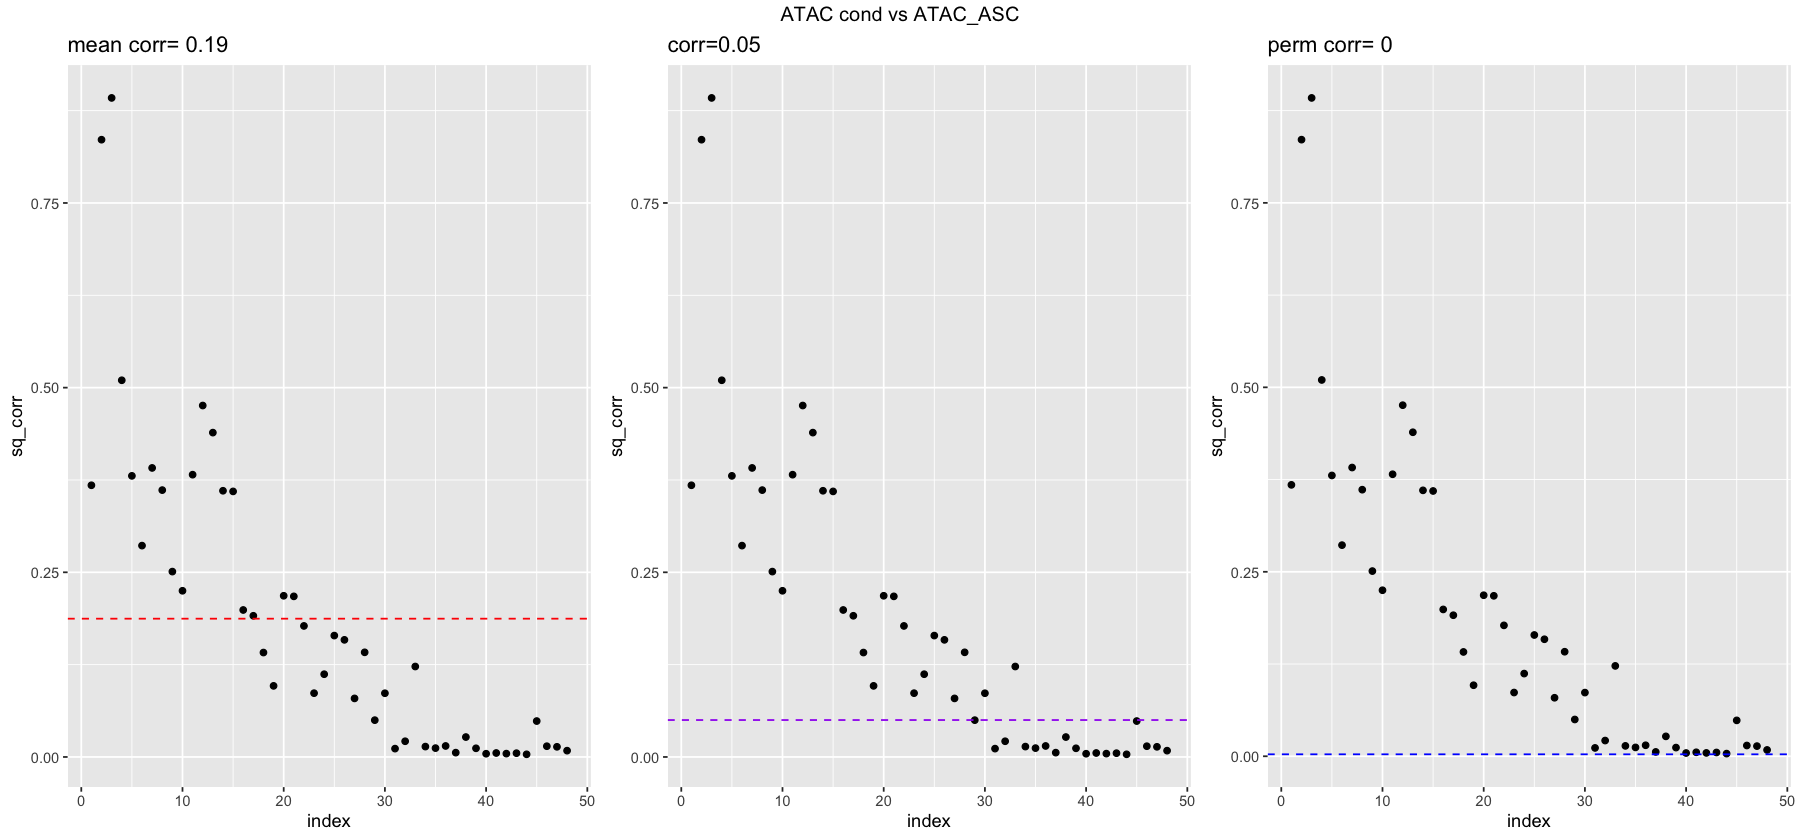

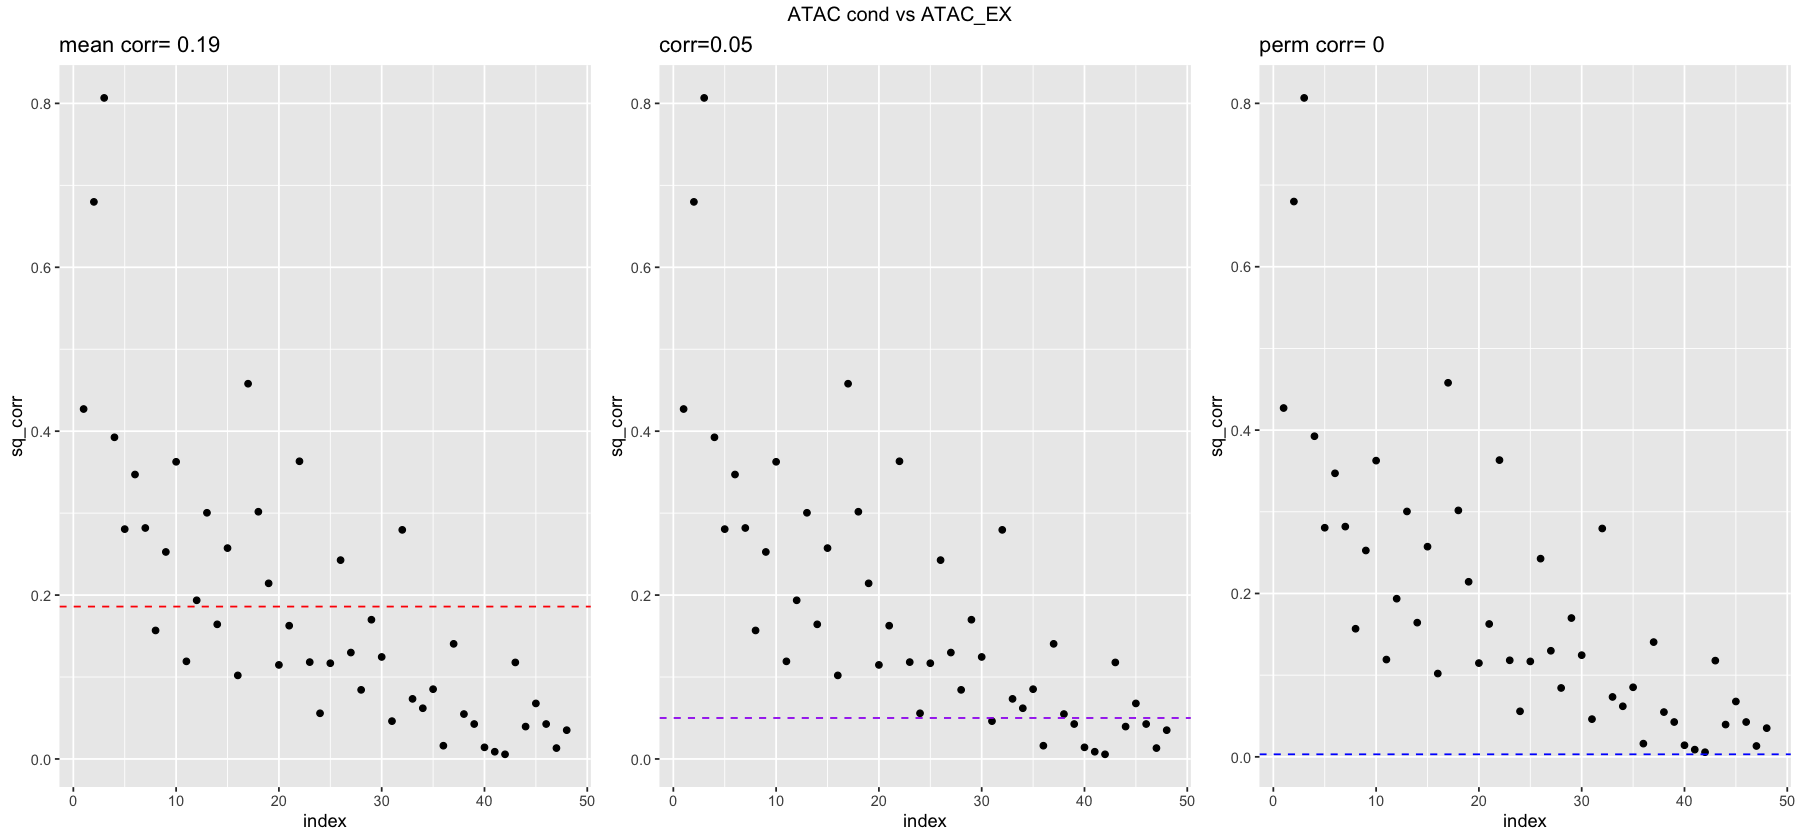

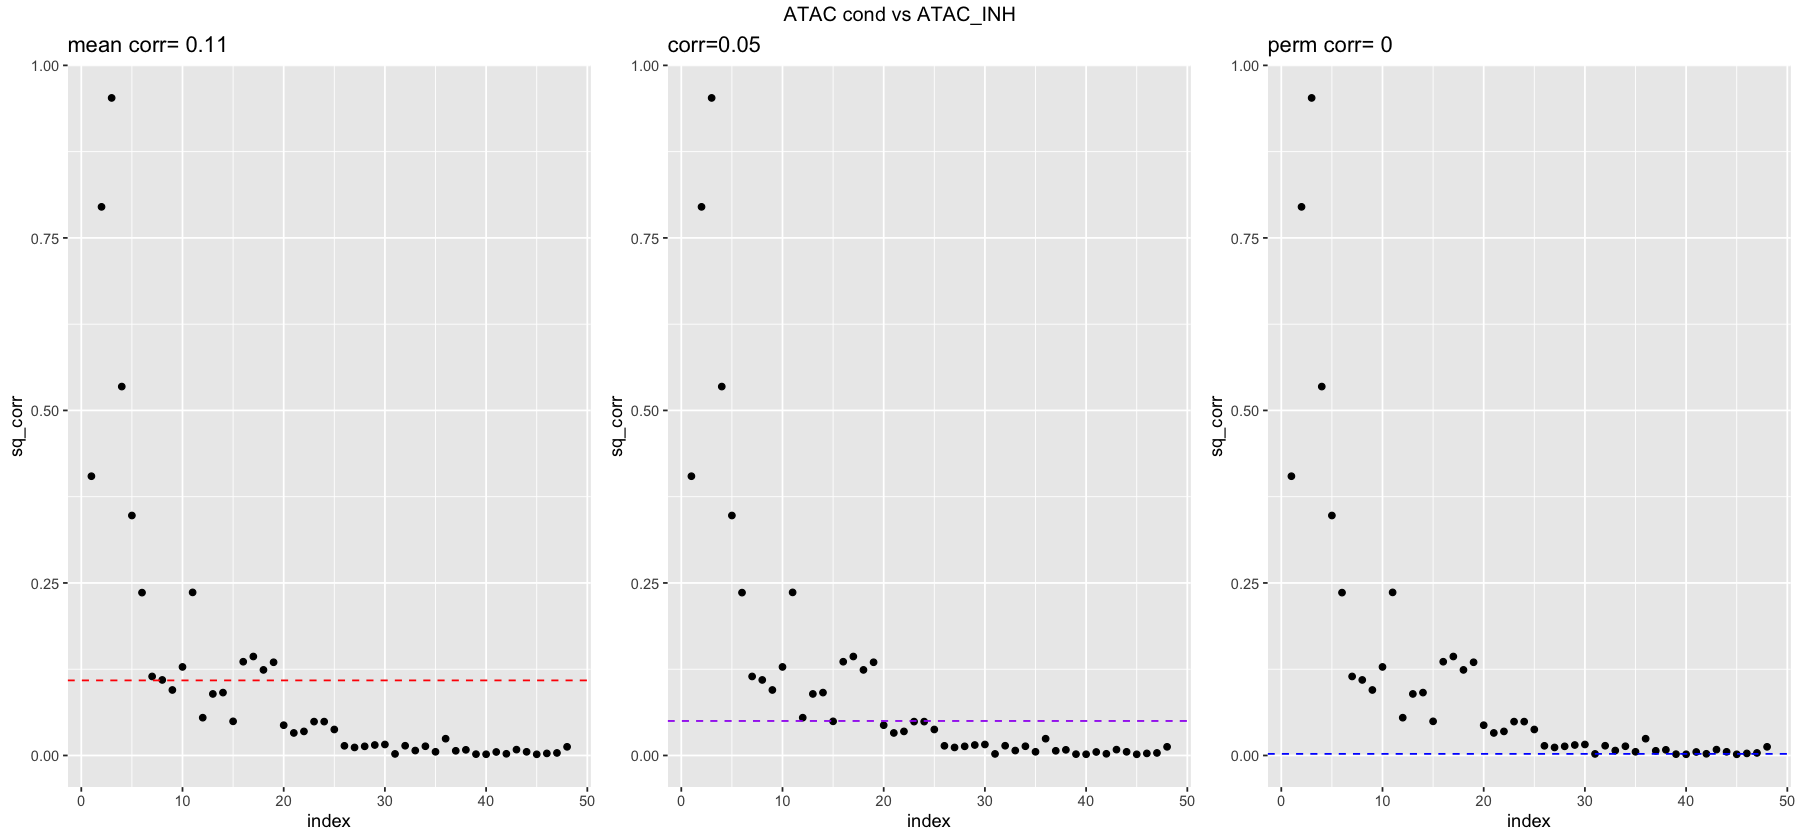

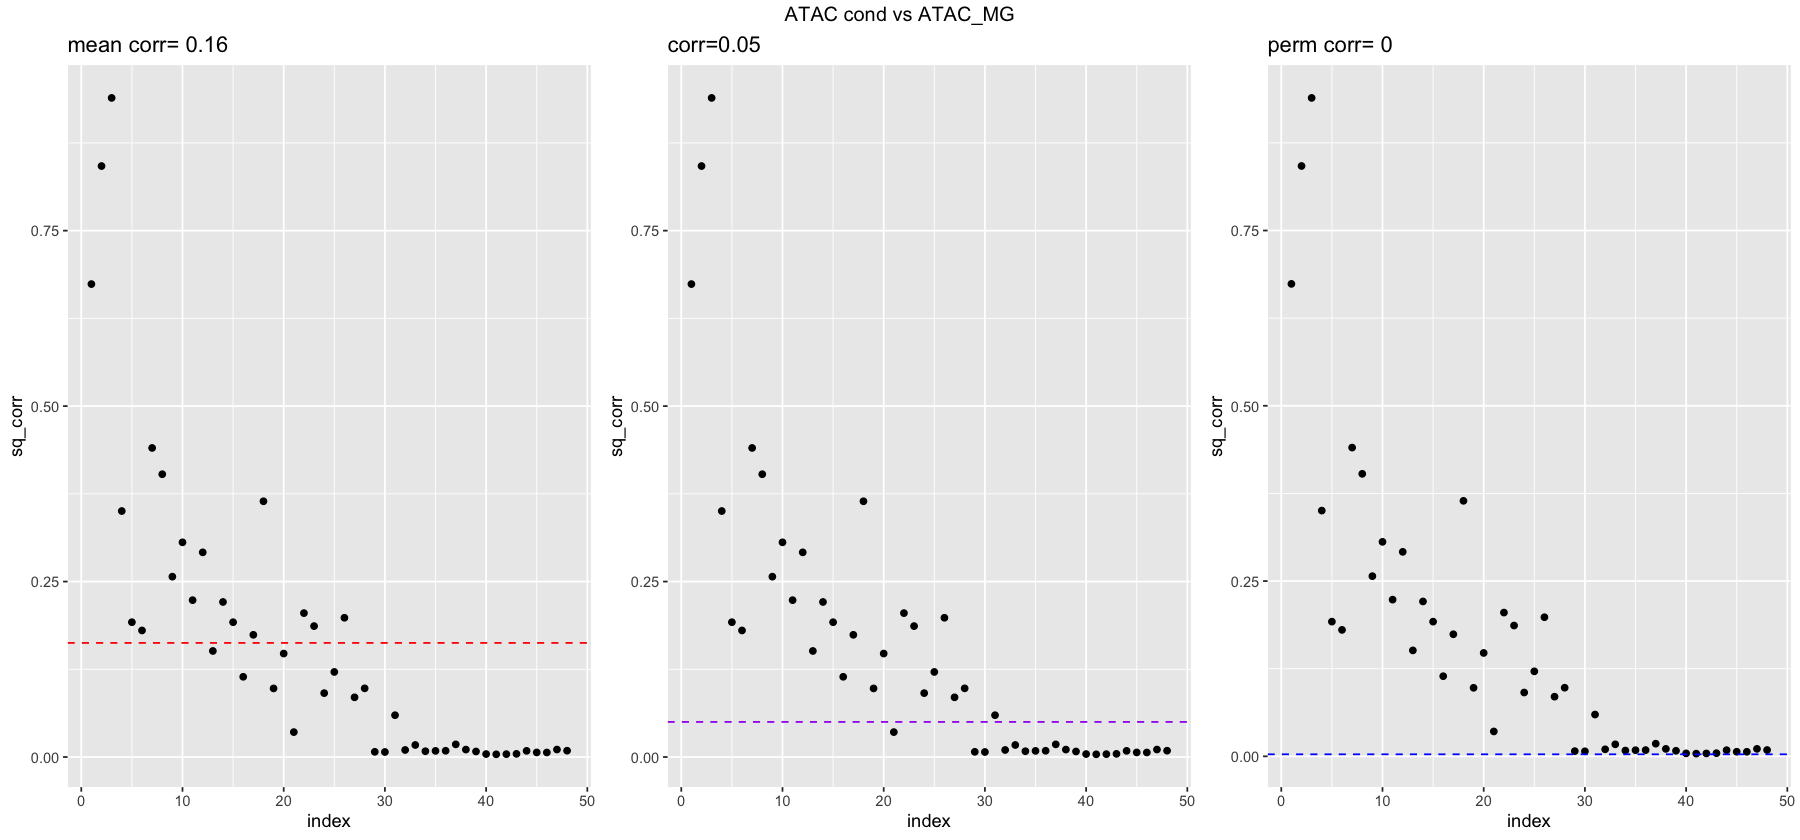

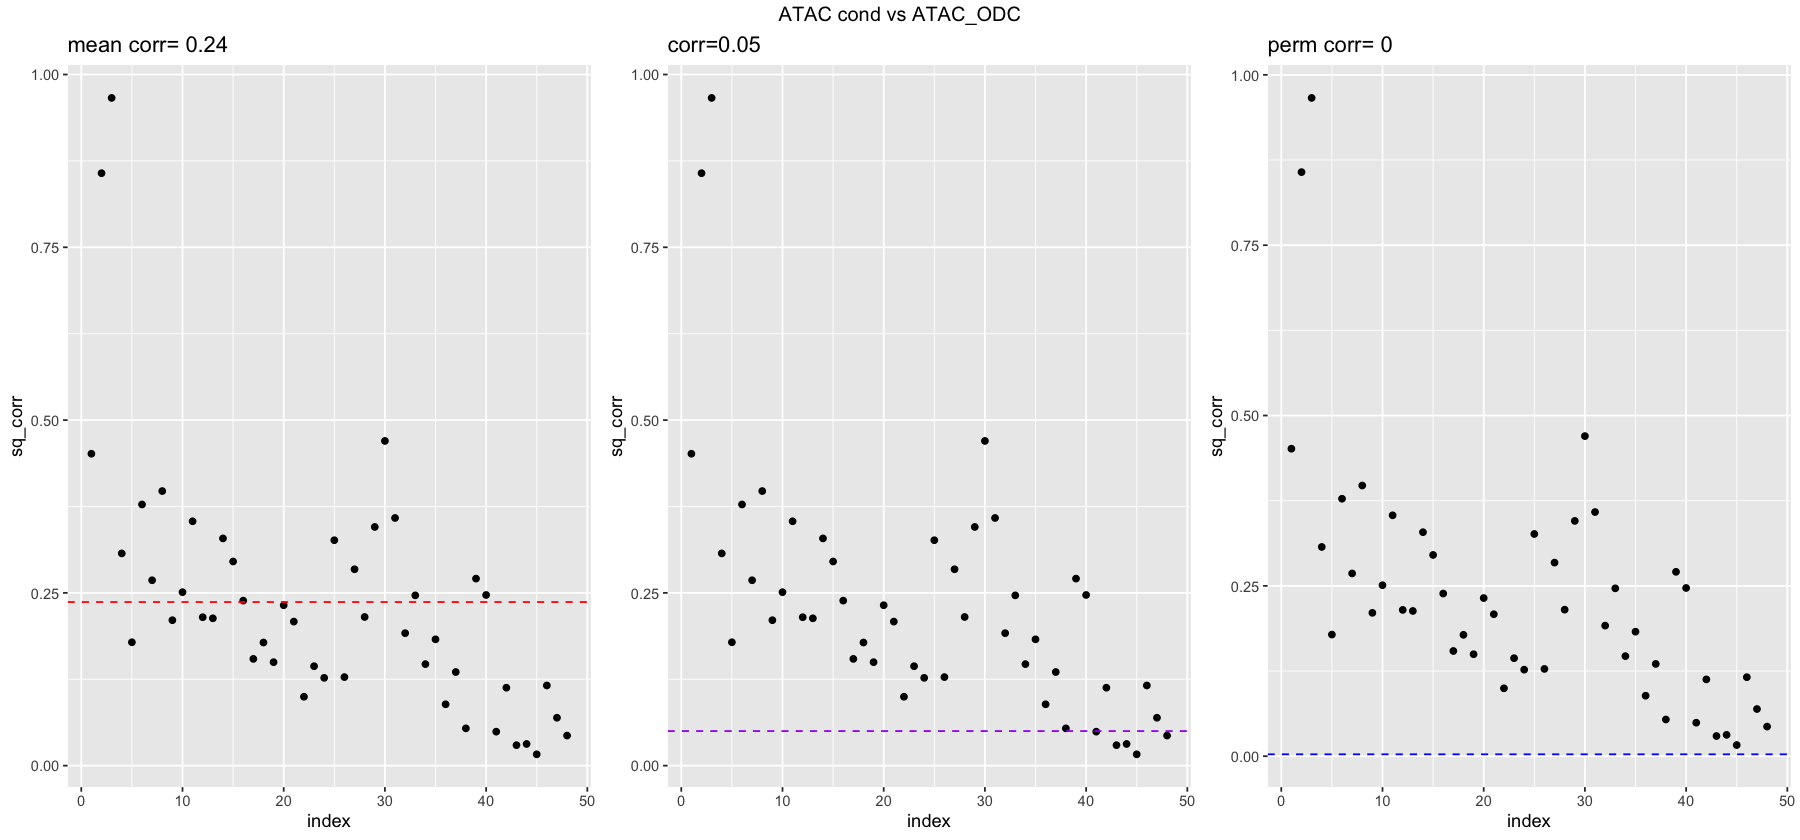

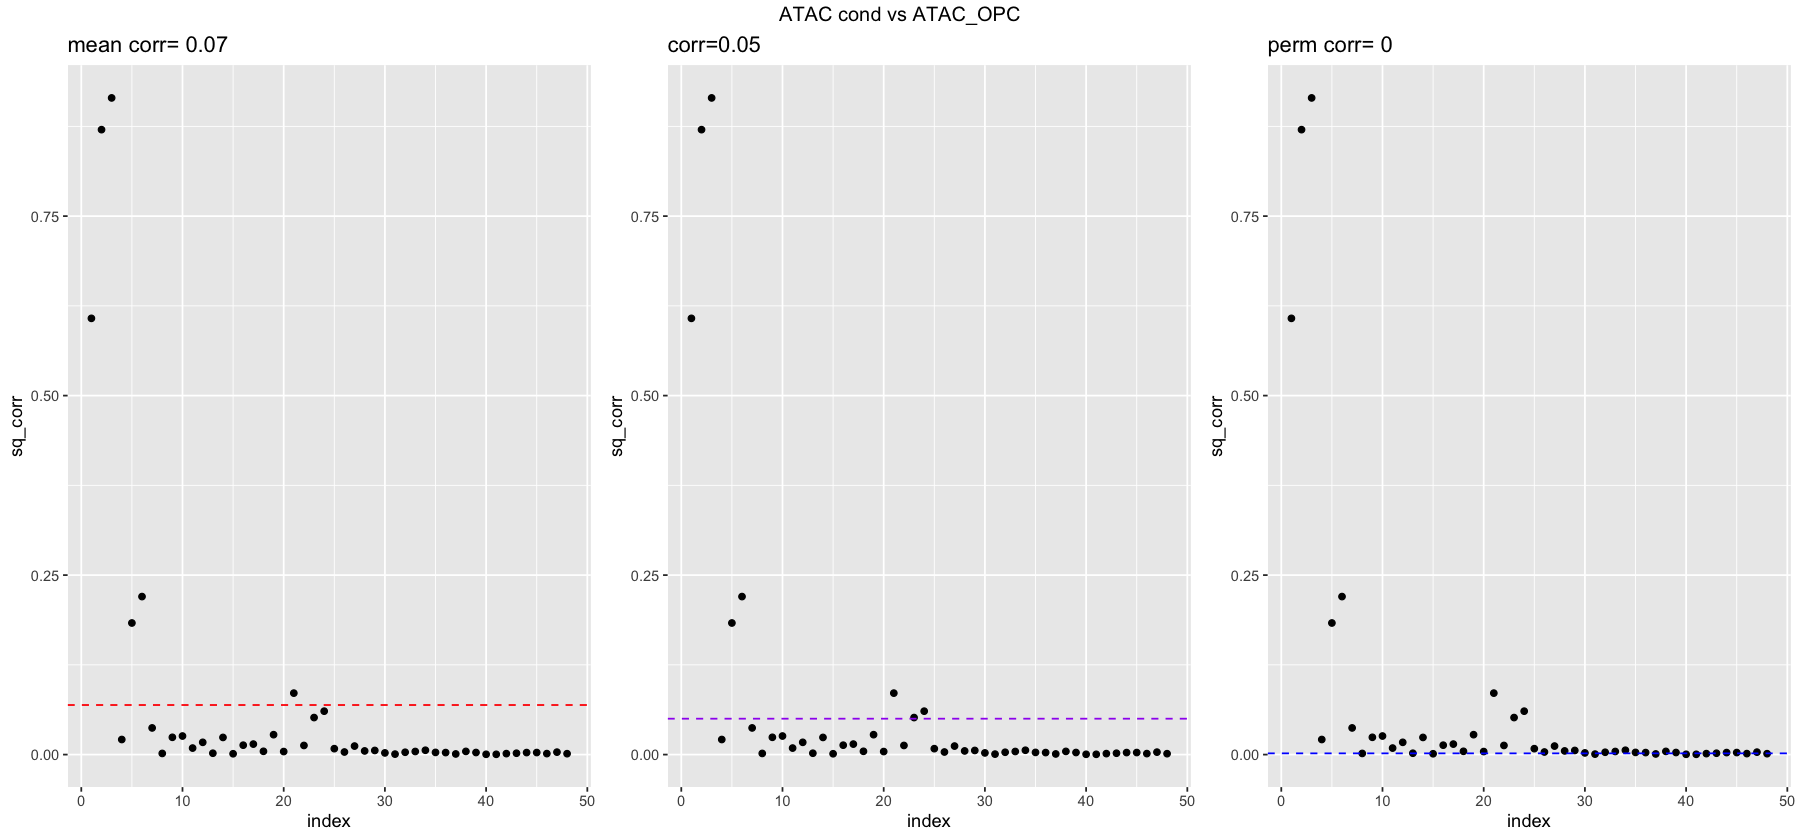

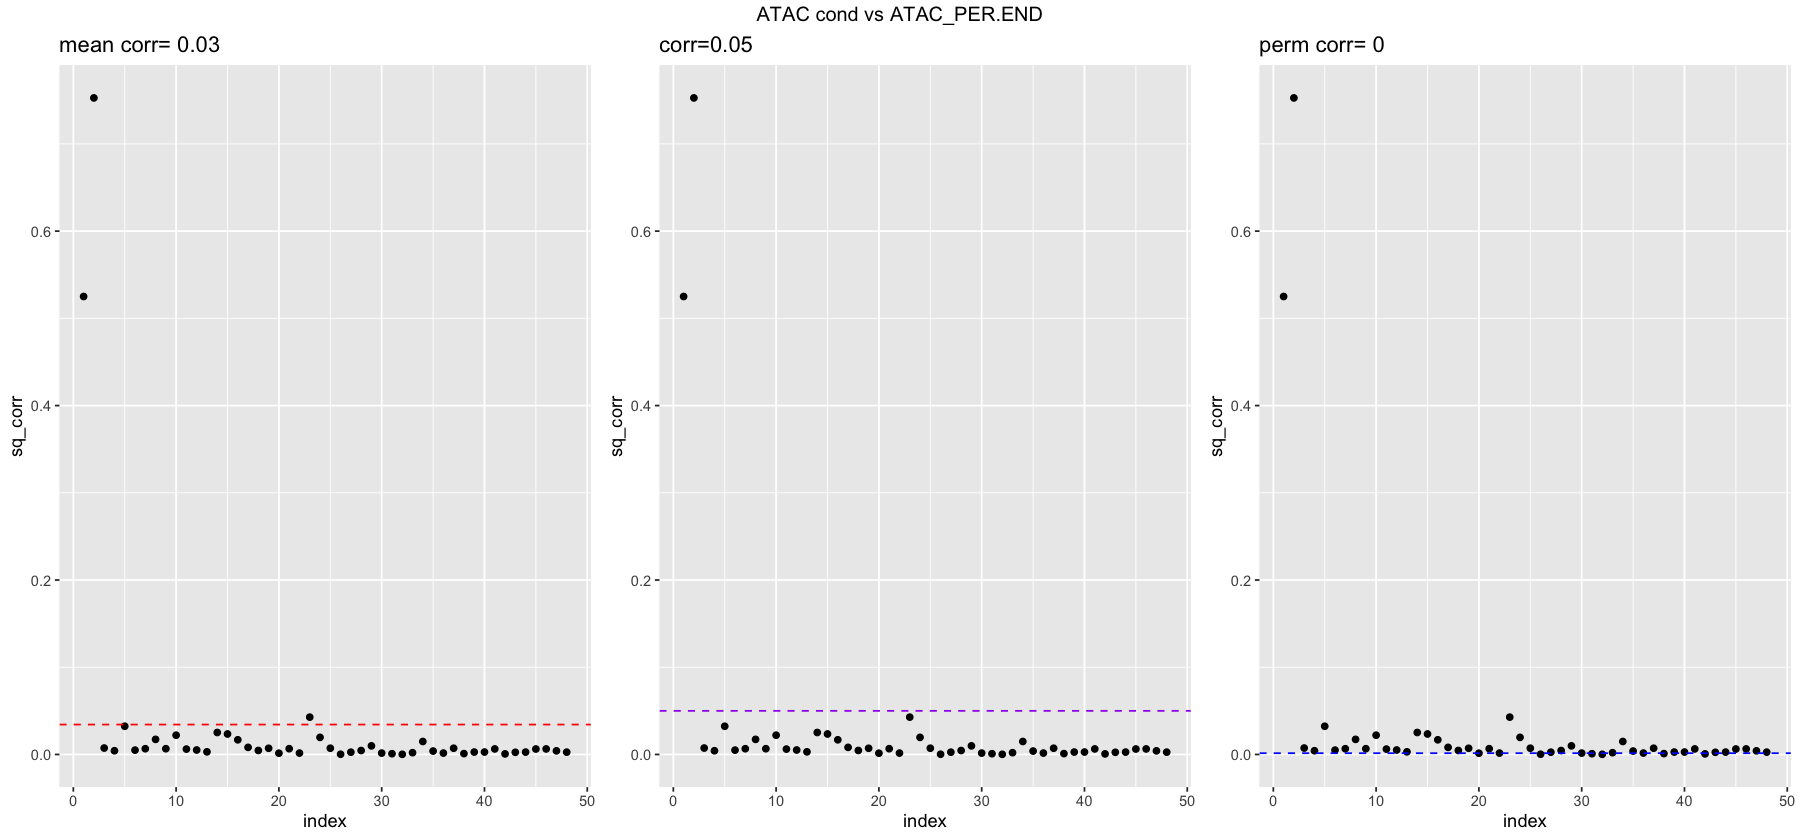

In [213]:
options(repr.plot.width = 15, repr.plot.height = 7)

compute_hist <- function(df1, df2, df1_name, df2_name, plot=NA,threshold=NA){
    # compute intersecting genes
    mutual_genes = intersect(rownames(df1), rownames(df2) )
    # subset both dataframes
    df1_mut = df1[mutual_genes,]
    df2_mut = df2[mutual_genes,]
    # compute squared correlation
    corr_matrix = cor(df1_mut,df2_mut)**2
    # compute maximum squared correlation
    # take the max over the larger dimension to capture all of the correlations
    if (dim(corr_matrix)[1] >= dim(corr_matrix)[2]){

        max_corrs = data.frame(apply(corr_matrix,1,max) )
        
    } else if (dim(corr_matrix)[1] < dim(corr_matrix)[2]) {

        max_corrs = data.frame(apply(corr_matrix,2,max) )

    } else {
        stop("weird dimensions of correlation matrix")
    }
    colnames(max_corrs) = "sq_corr"
    max_corrs$index = 1:dim(max_corrs)[1]
    # compute list of PCs that are below the threshold, therefore, not found in the iterative method
    if (is.na(threshold)){

        out = rownames(max_corrs[max_corrs$sq_corr > mean(max_corrs$sq_corr),])

    } else {

        out = rownames(max_corrs[max_corrs$sq_corr > threshold,])
        
    }
    

    # perform permutation test to compute threshold cutoff
    perm_df1 = df1_mut
    vec_of_perm_max_vals = rep(NA, 10)
    for (perm in 1:10){
        rownames(perm_df1) = sample(rownames(df1_mut), length(rownames(df1_mut)) )
        # reorder properly
        perm_df1_mut = perm_df1[mutual_genes,]

        # compute squared correlation
        perm_corr_matrix = cor(perm_df1_mut,df2_mut)**2

        # take the max over the larger dimension to capture all of the correlations
        if (dim(perm_corr_matrix)[1] >= dim(perm_corr_matrix)[2]){

            perm_max_corrs = data.frame(apply(perm_corr_matrix,1,max) )
            
        } else if (dim(perm_corr_matrix)[1] < dim(perm_corr_matrix)[2]) {

            perm_max_corrs = data.frame(apply(perm_corr_matrix,2,max) )

        } else {
            stop("weird dimensions of correlation matrix")
            }

        # average this permutation

        vec_of_perm_max_vals[perm] = apply(perm_max_corrs, 2, mean)

    }
    
    threshold_by_perm_test = mean(vec_of_perm_max_vals)

    if (!is.na(plot)){
        
        plot1 = ggplot(max_corrs, aes(x=index, y=sq_corr)) + geom_point() + geom_hline(yintercept = mean(max_corrs$sq_corr), linetype=2, col = 'red') + ggtitle(paste('mean corr=',round(mean(max_corrs$sq_corr),2)))

        plot2 = ggplot(max_corrs, aes(x=index, y=sq_corr)) + geom_point() + geom_hline(yintercept = 0.05, linetype=2, col = 'purple') + ggtitle(paste('corr=0.05'))
    
        plot3 = ggplot(max_corrs, aes(x=index, y=sq_corr)) + geom_point() + geom_hline(yintercept =threshold_by_perm_test, linetype=2, col = 'blue') + ggtitle(paste('perm corr=',round(threshold_by_perm_test,2)))

        grid.arrange(plot1, plot2, plot3, ncol=3, top = paste(df1_name, "vs",df2_name))

    }

    if (is.na(plot)){

        return(out)

    }
    
}

compute_hist(df1 = stand, df2 = ASC,df1_name = "ATAC Stand", df2_name = "ATAC_ASC", plot=TRUE)
compute_hist(df1 = stand, df2 = EX,df1_name = "ATAC Stand", df2_name = "ATAC_EX", plot=TRUE)
compute_hist(df1 = stand, df2 = INH,df1_name = "ATAC Stand", df2_name = "ATAC_INH", plot=TRUE)
compute_hist(df1 = stand, df2 = MG,df1_name = "ATAC Stand", df2_name = "ATAC_MG", plot=TRUE)
compute_hist(df1 = stand, df2 = ODC,df1_name = "ATAC Stand", df2_name = "ATAC_ODC", plot=TRUE)
compute_hist(df1 = stand, df2 = OPC,df1_name = "ATAC Stand", df2_name = "ATAC_OPC", plot=TRUE)
compute_hist(df1 = stand, df2 = PER.END,df1_name = "ATAC Stand", df2_name = "ATAC_PER.END", plot=TRUE)

compute_hist(df1 = cond, df2 = ASC,df1_name = "ATAC cond", df2_name = "ATAC_ASC", plot=TRUE)
compute_hist(df1 = cond, df2 = EX,df1_name = "ATAC cond", df2_name = "ATAC_EX", plot=TRUE)
compute_hist(df1 = cond, df2 = INH,df1_name = "ATAC cond", df2_name = "ATAC_INH", plot=TRUE)
compute_hist(df1 = cond, df2 = MG,df1_name = "ATAC cond", df2_name = "ATAC_MG", plot=TRUE)
compute_hist(df1 = cond, df2 = ODC,df1_name = "ATAC cond", df2_name = "ATAC_ODC", plot=TRUE)
compute_hist(df1 = cond, df2 = OPC,df1_name = "ATAC cond", df2_name = "ATAC_OPC", plot=TRUE)
compute_hist(df1 = cond, df2 = PER.END,df1_name = "ATAC cond", df2_name = "ATAC_PER.END", plot=TRUE)




In [214]:
indep_stand_ATAC = (dim(stand)[2] - length(unique(unlist(lapply(list(ASC,EX,INH,MG,ODC,OPC,PER.END),df1 = stand, df1_name=NA, df2_name=NA, threshold=0.2,FUN=compute_hist) ) ) ) ) / dim(stand)[2]


indep_cond_ATAC = (dim(cond)[2] - length(unique(unlist(lapply(list(ASC,EX,INH,MG,ODC,OPC,PER.END),df1 = cond, df1_name=NA, df2_name=NA, threshold=0.2, FUN=compute_hist) ) ) ) ) / dim(cond)[2]
indep_stand_ATAC
indep_cond_ATAC

[1] 0.3846154

[1] 0.3125

In [215]:
# RNA
stand = read.csv("~/Downloads/RNA/Morabito_RNA_Standard_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_Standard_PCA"),]$BIC]
cond = read.csv("~/Downloads/RNA/Morabito_RNA_Conditional_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_Conditional_PCA"),]$BIC]
ASC = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_ASC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_ASC"),]$BIC]
EX = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_EX_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_EX"),]$BIC]
INH = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_INH_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_INH"),]$BIC]
MG = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_MG_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_MG"),]$BIC]
ODC = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_ODC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_ODC"),]$BIC]
OPC = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_OPC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_OPC"),]$BIC]
PER.END = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_PER.END_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_PER.END"),]$BIC]


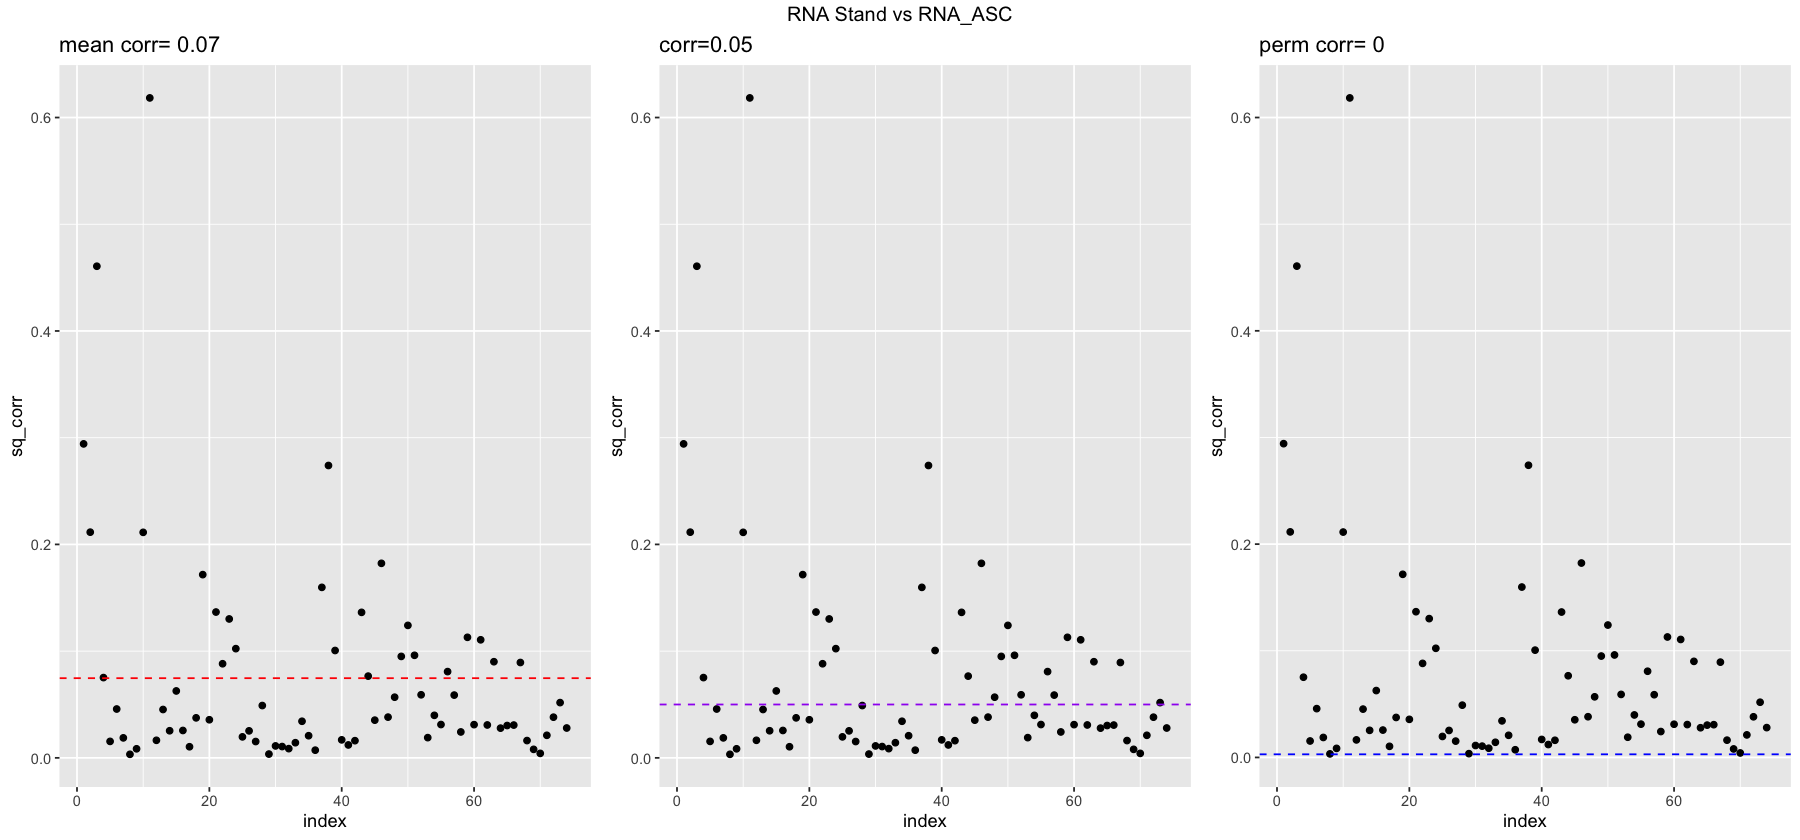

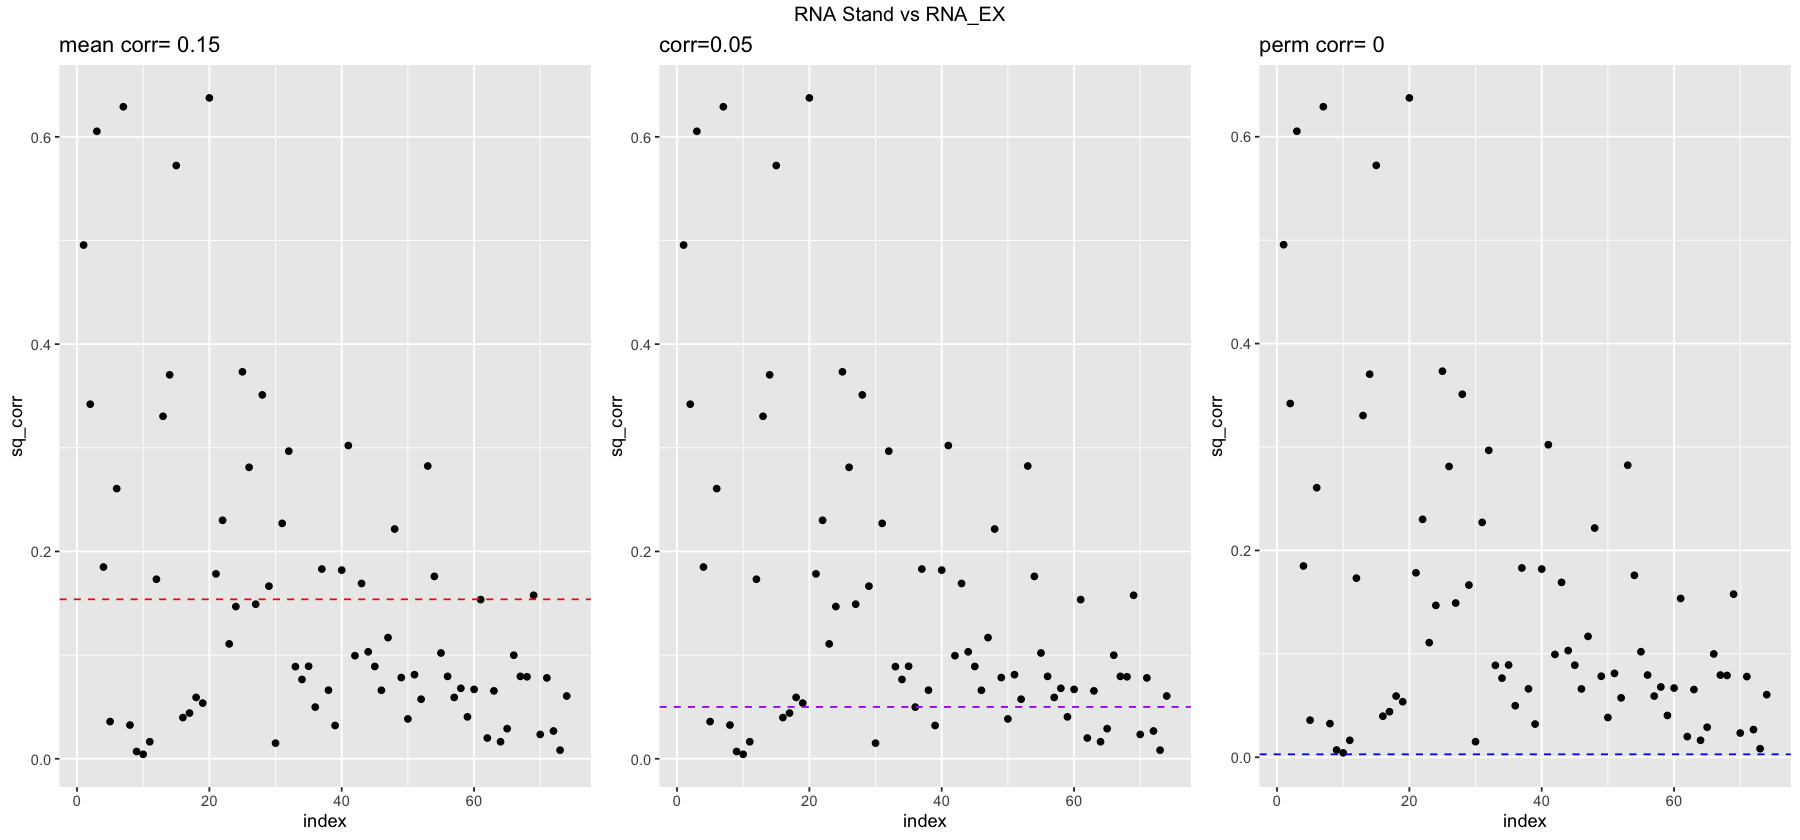

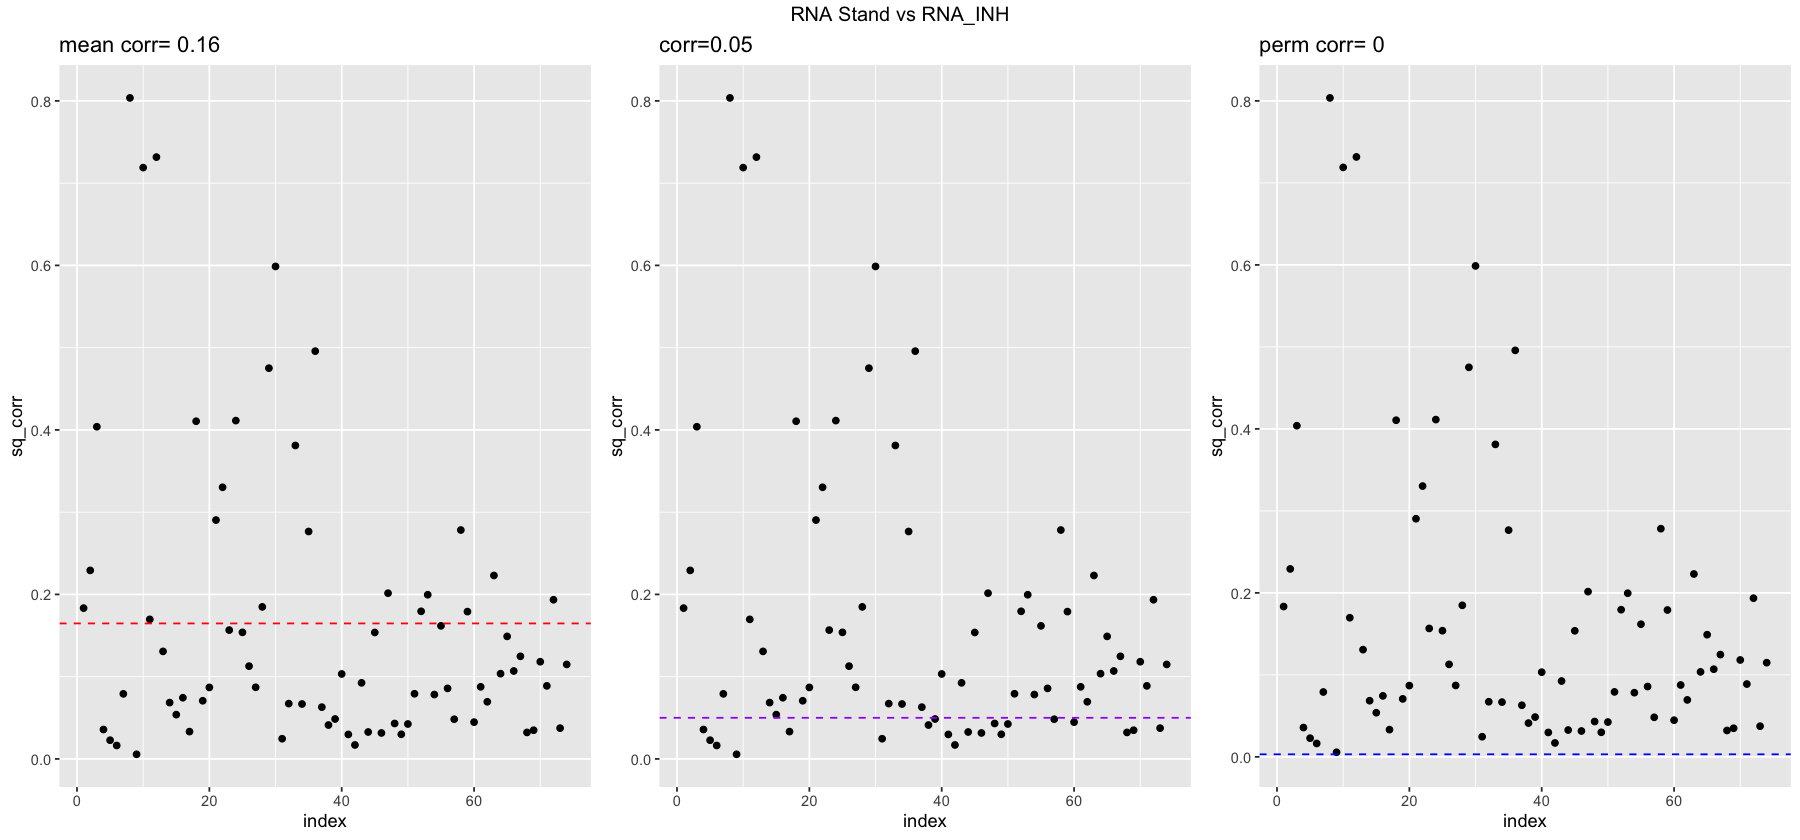

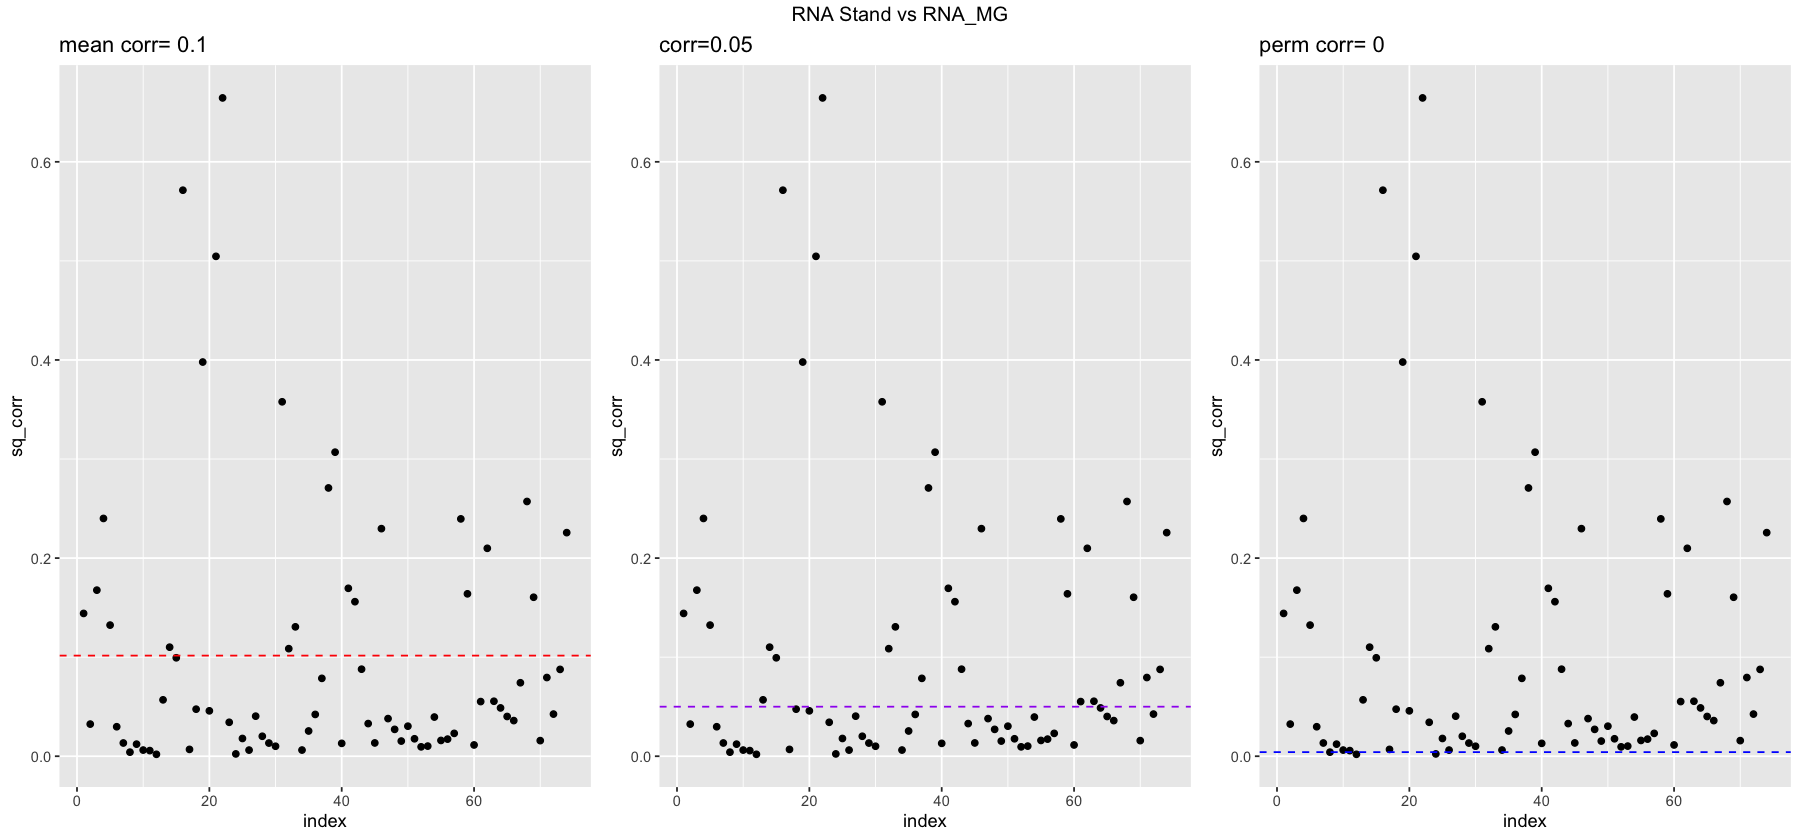

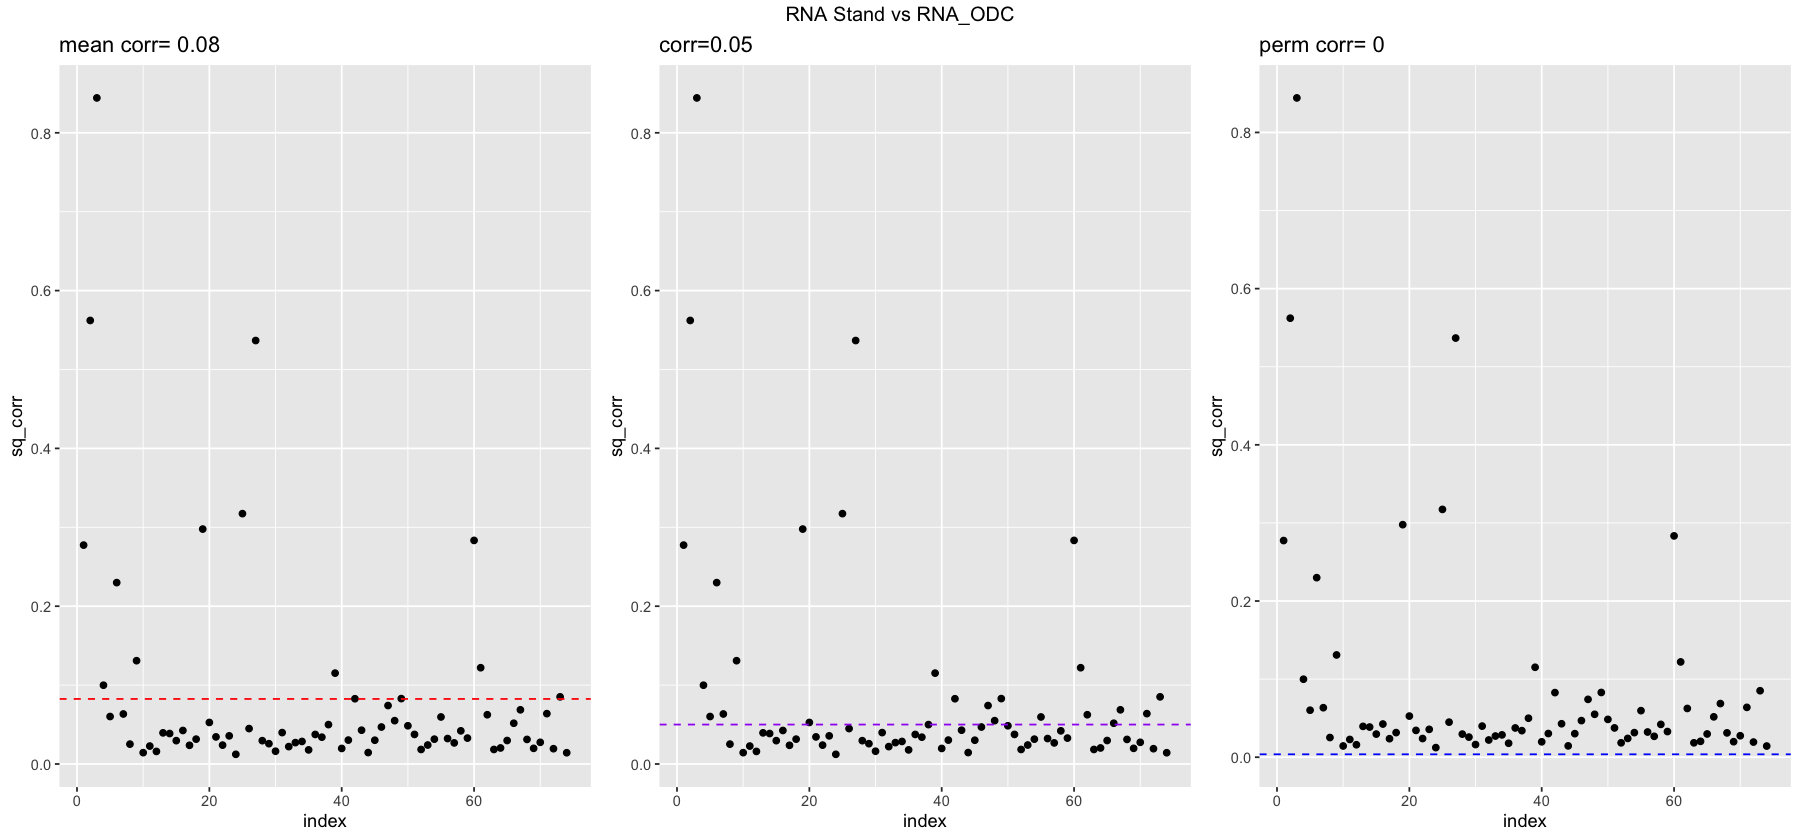

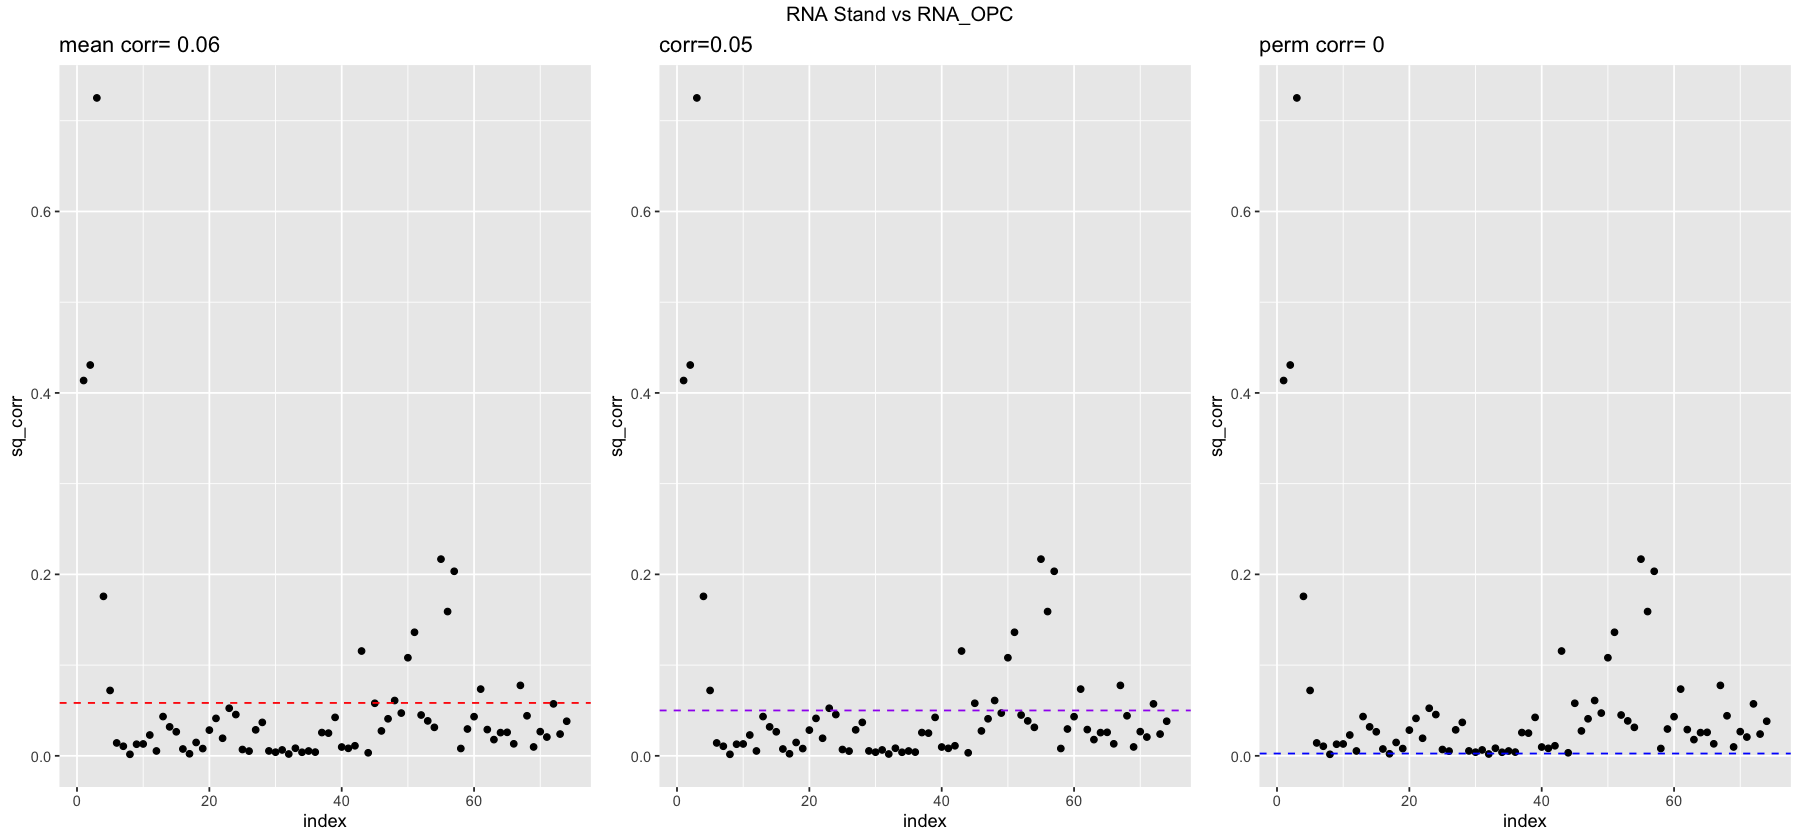

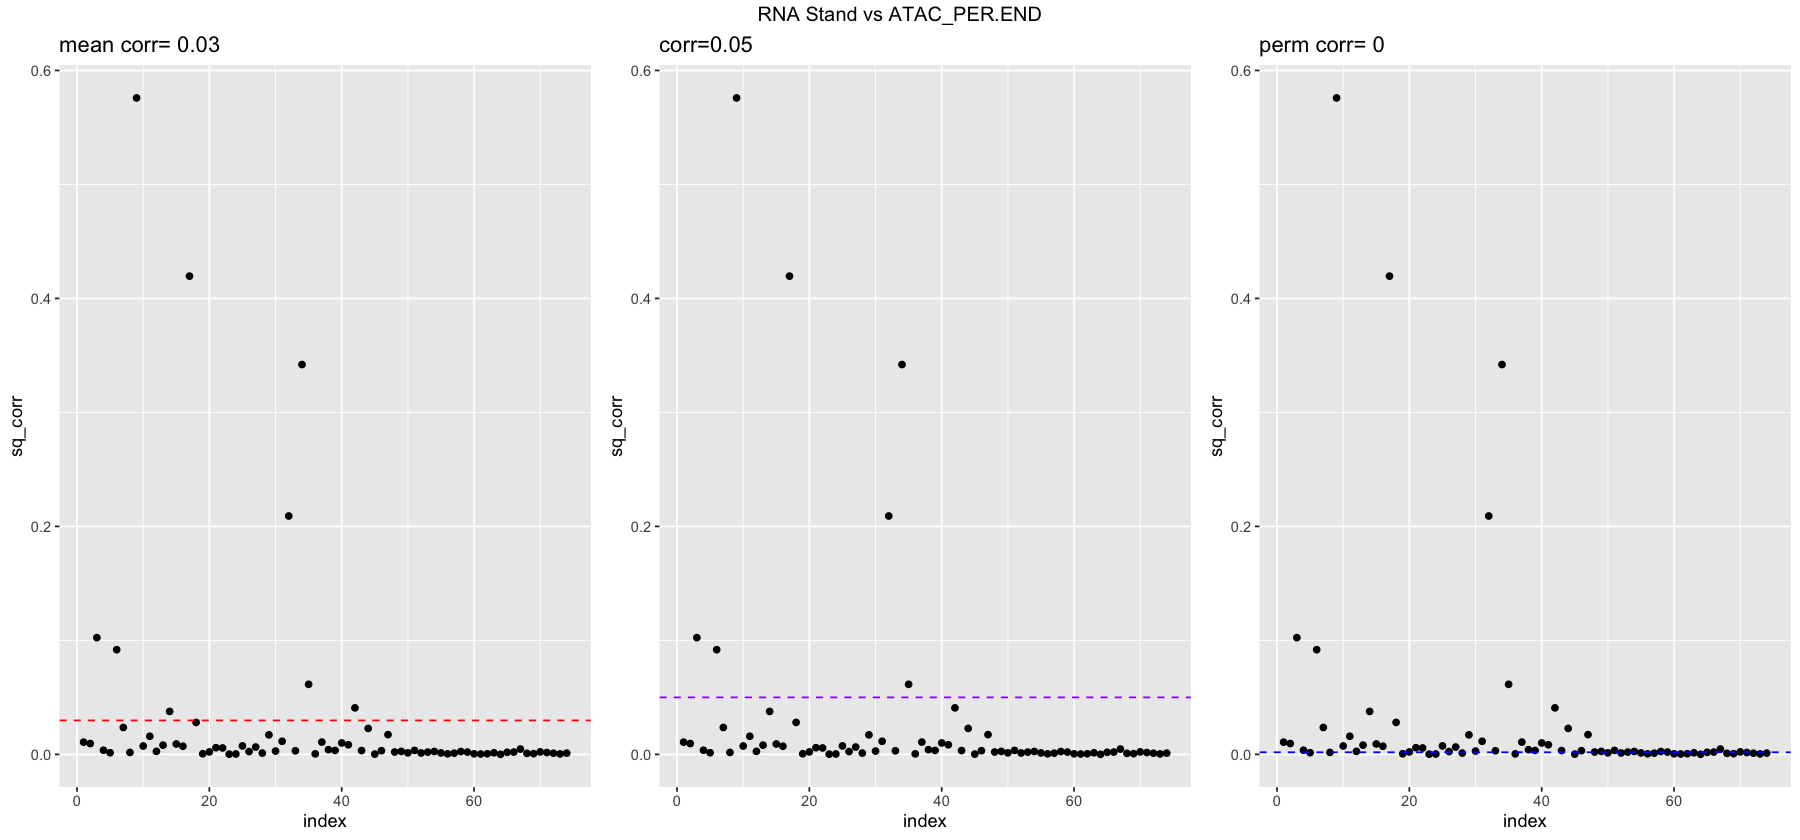

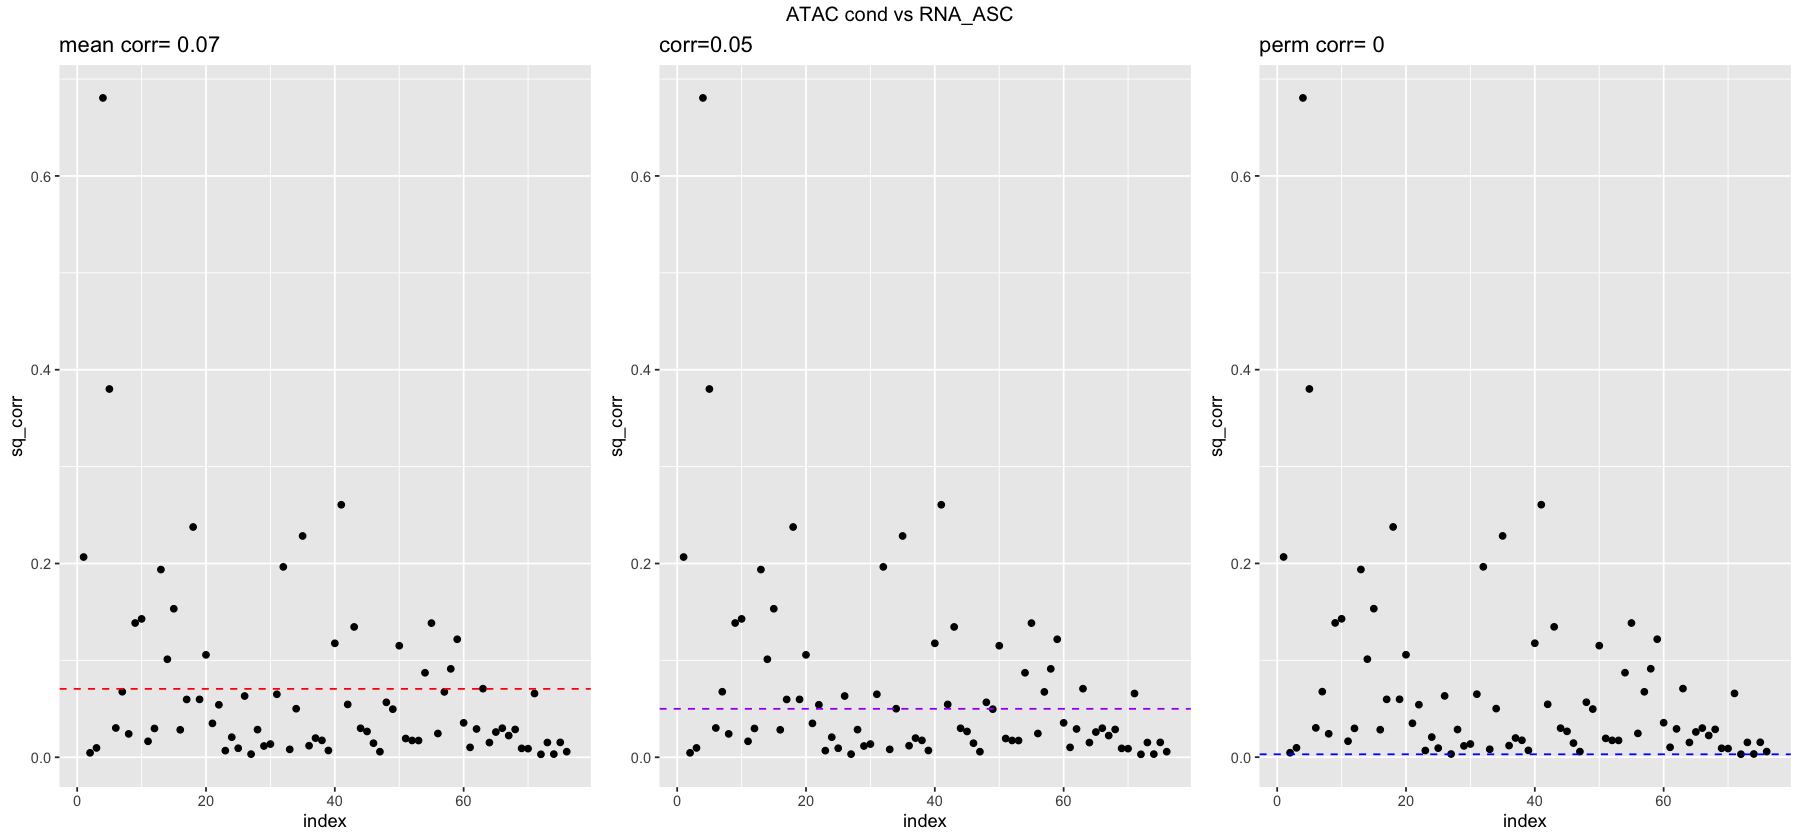

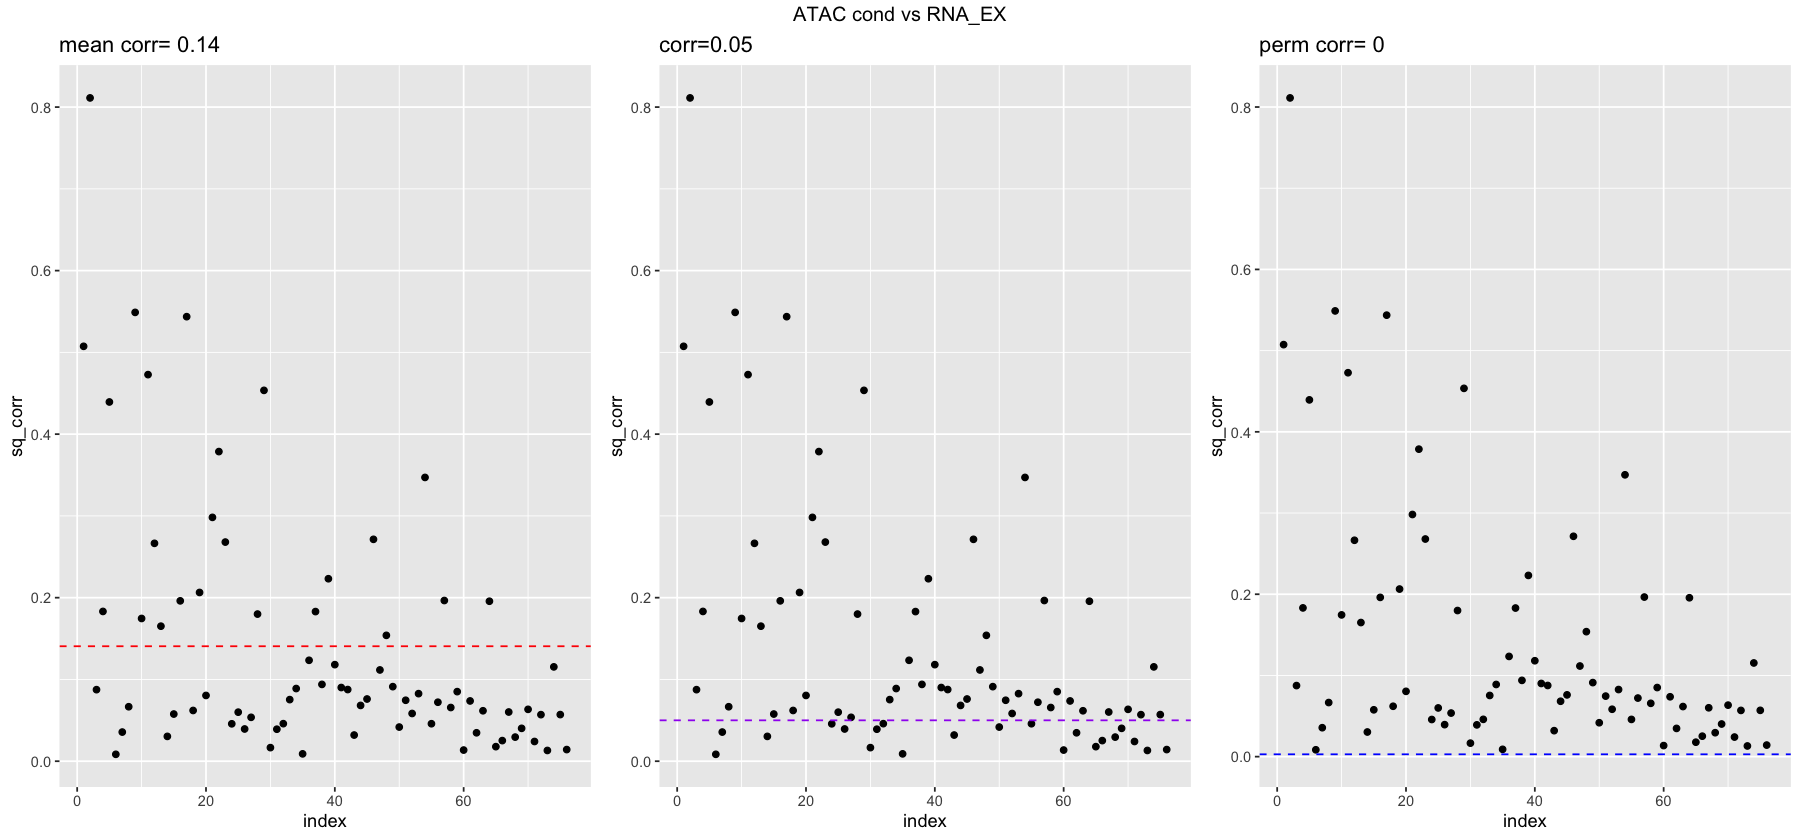

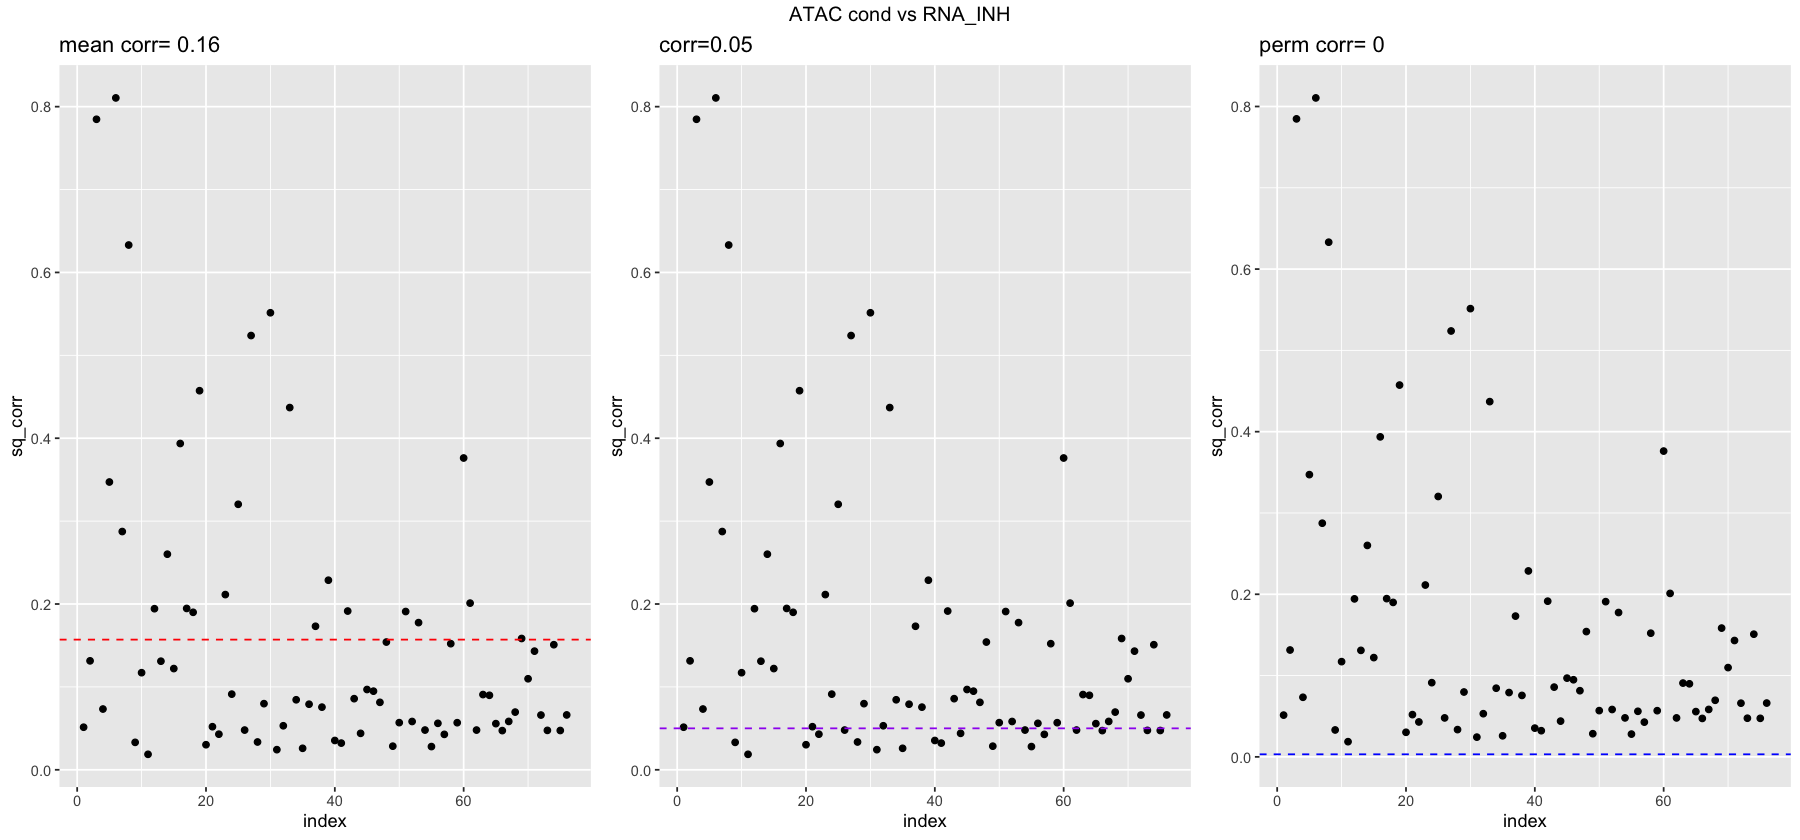

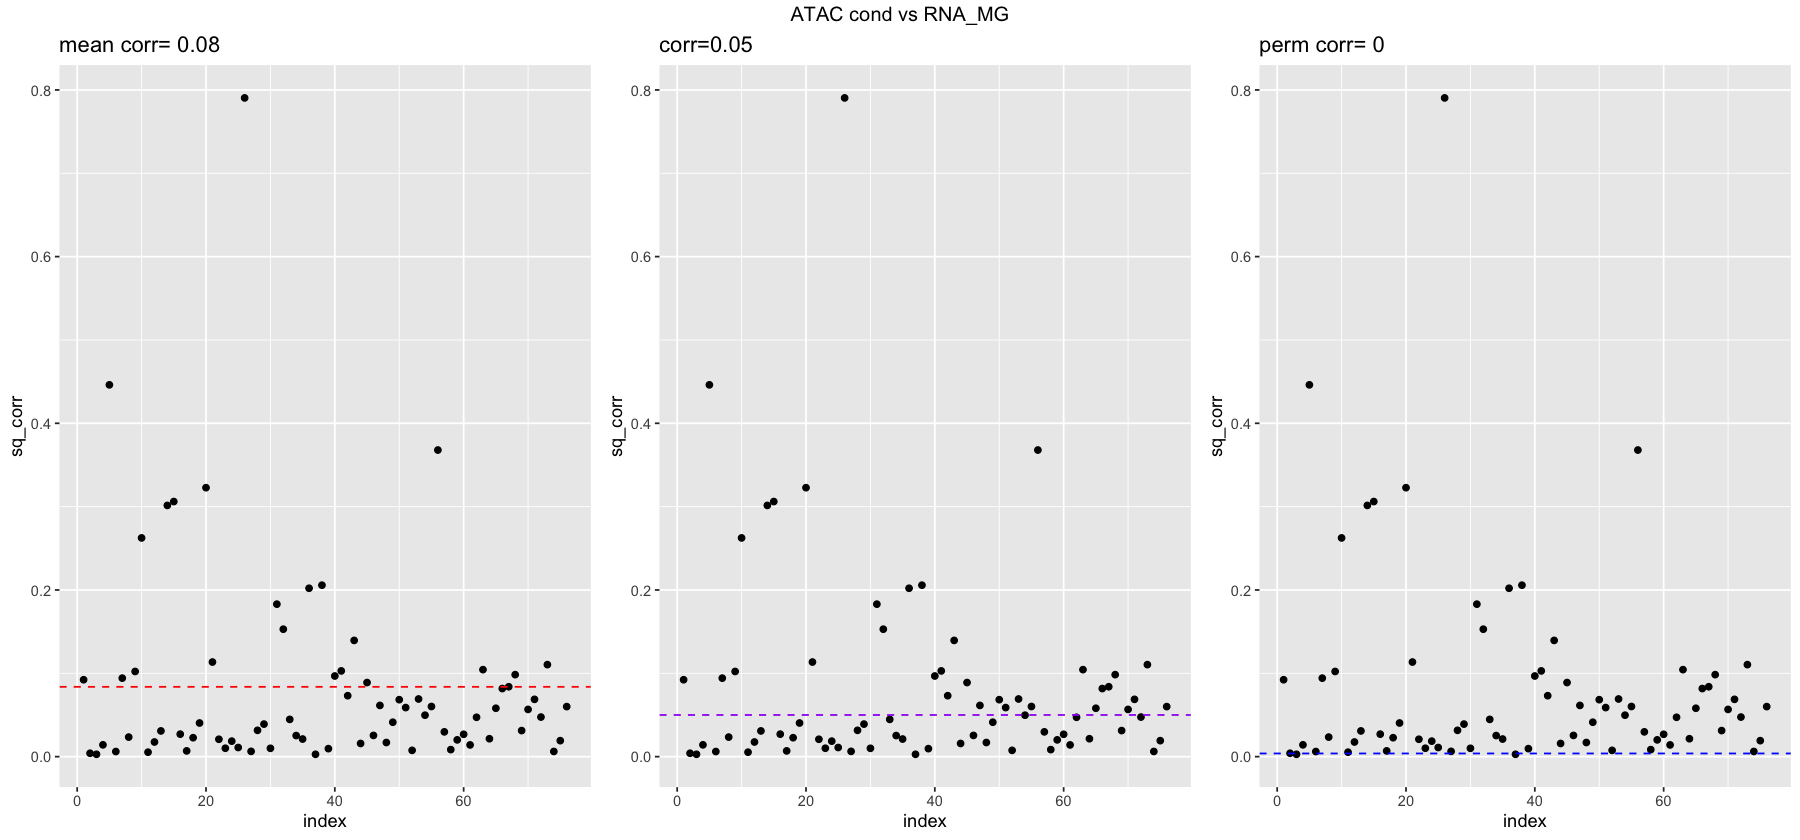

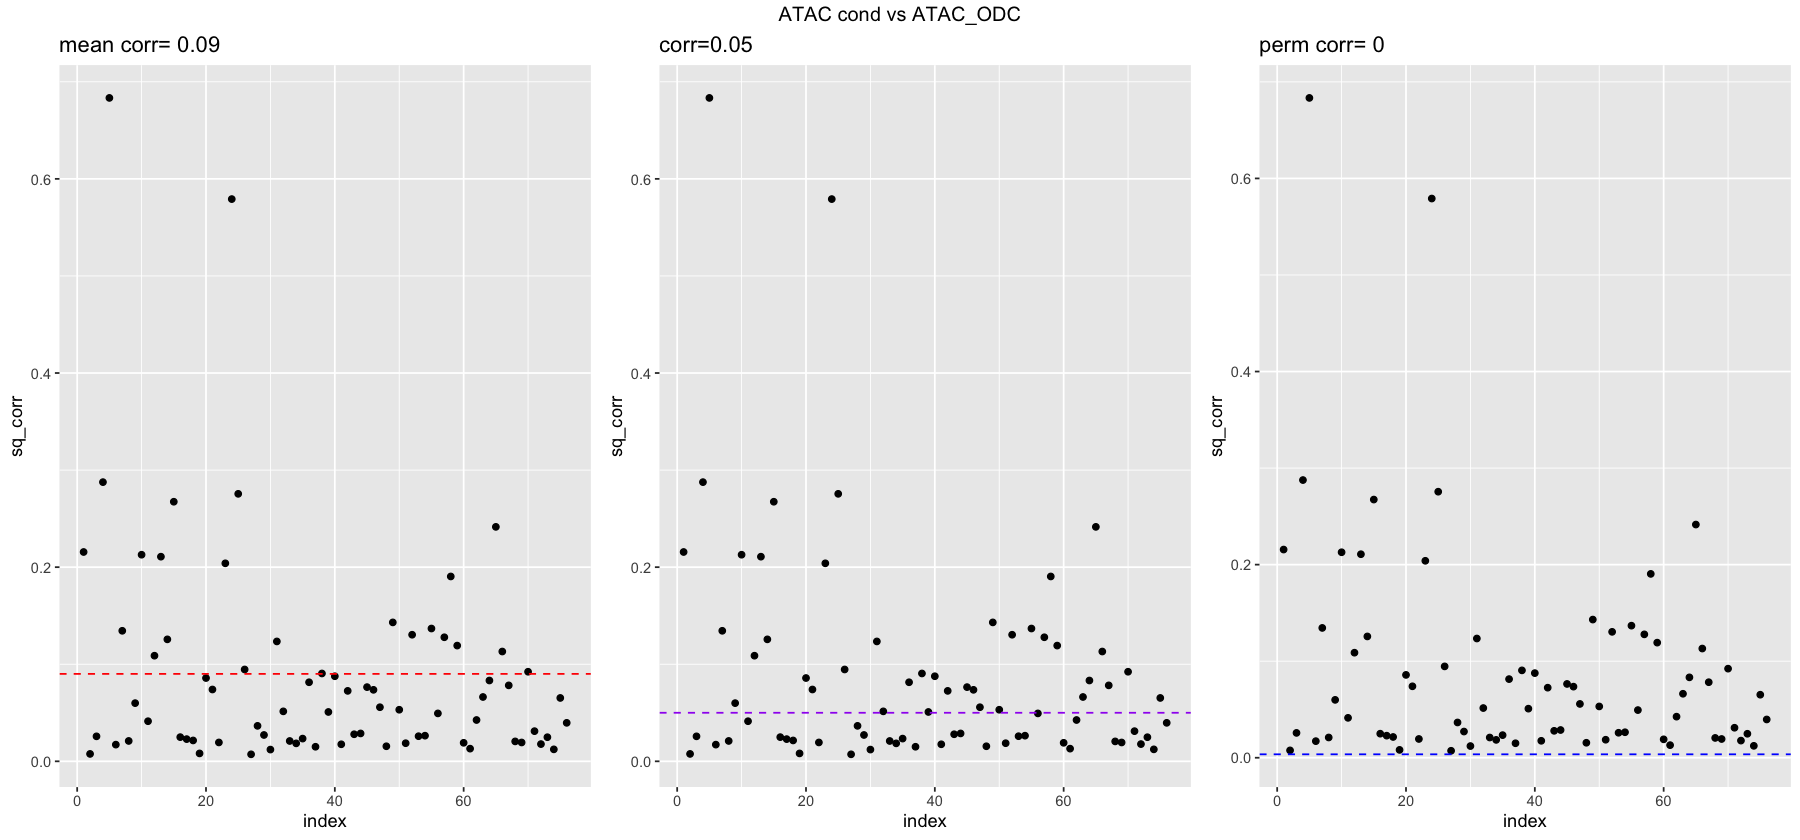

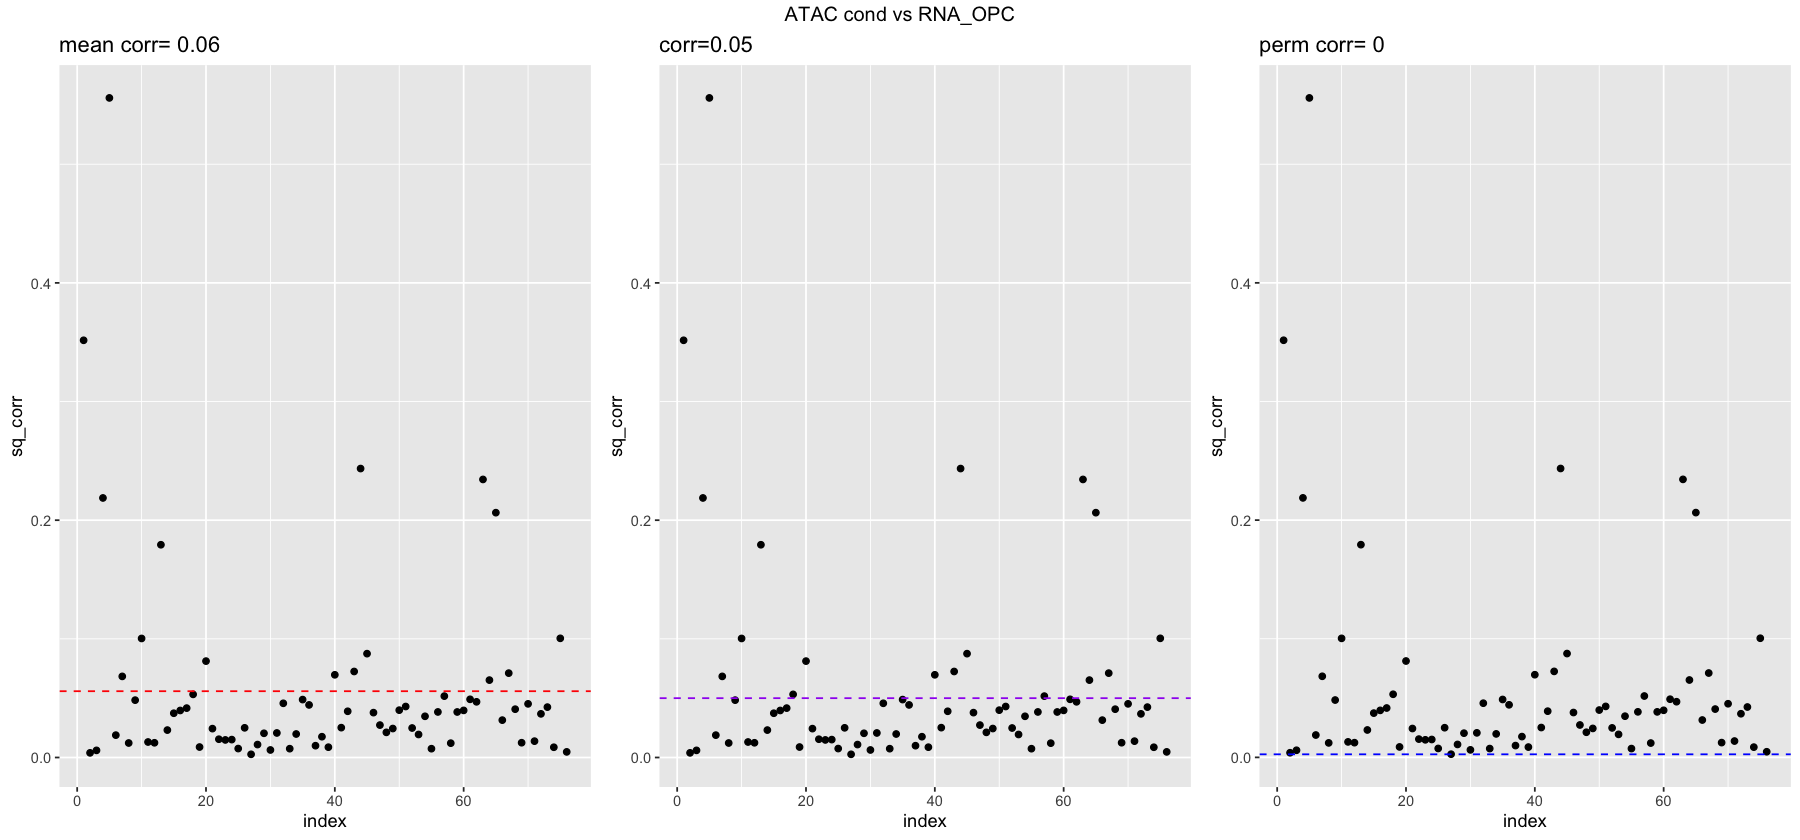

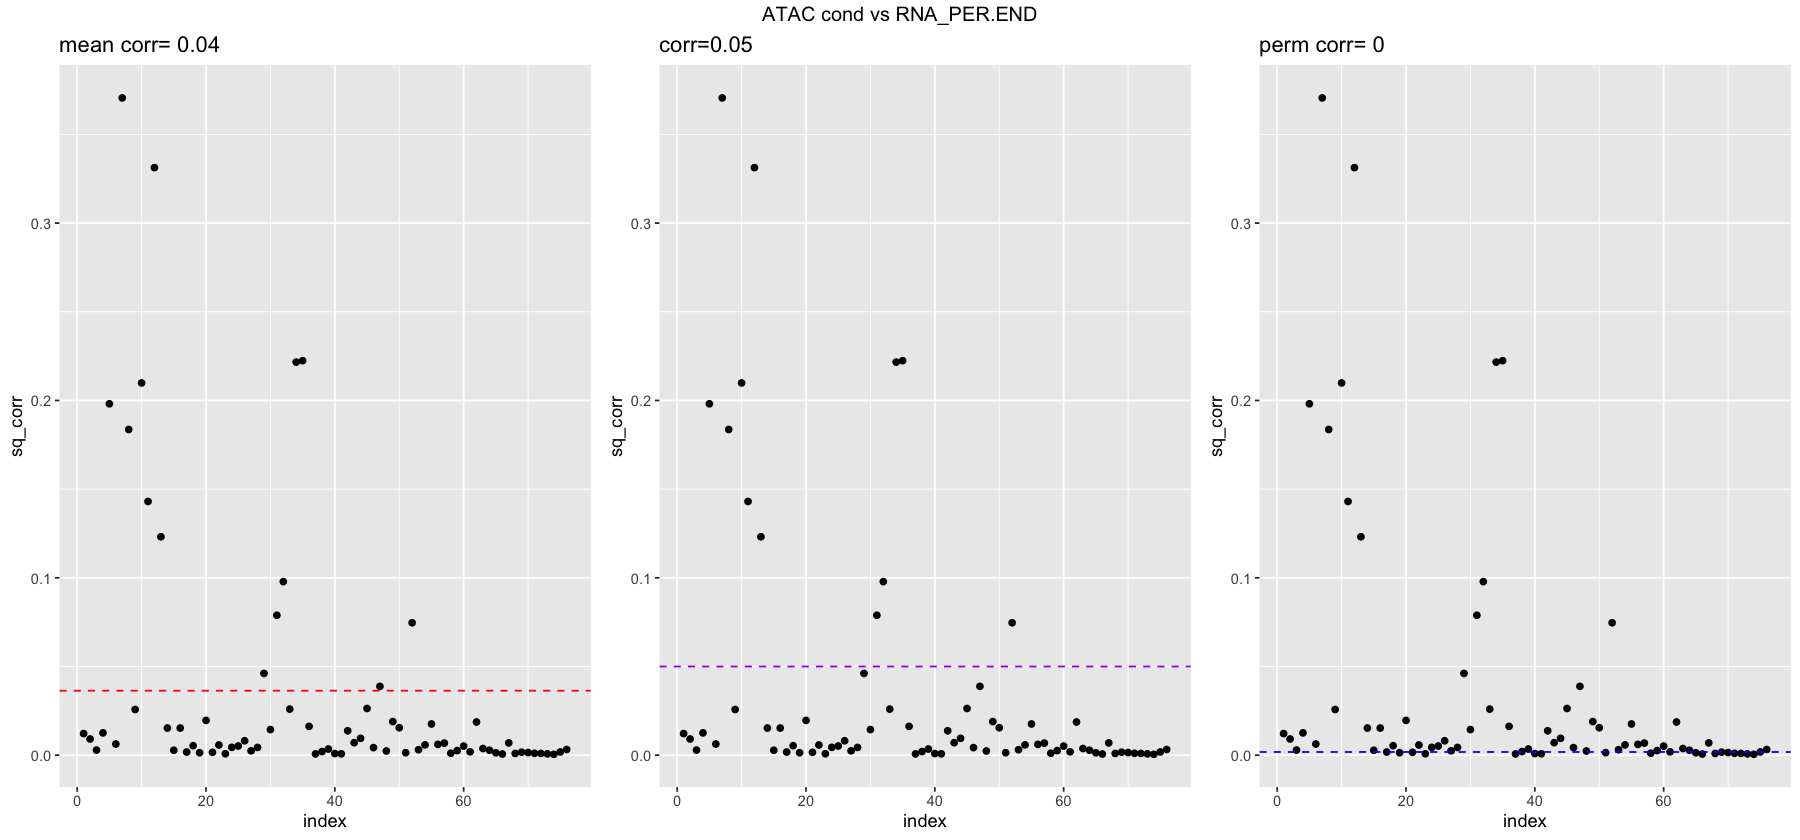

In [203]:
compute_hist(df1 = stand, df2 = ASC,df1_name = "RNA Stand", df2_name = "RNA_ASC", plot=TRUE)
compute_hist(df1 = stand, df2 = EX,df1_name = "RNA Stand", df2_name = "RNA_EX", plot=TRUE)
compute_hist(df1 = stand, df2 = INH,df1_name = "RNA Stand", df2_name = "RNA_INH", plot=TRUE)
compute_hist(df1 = stand, df2 = MG,df1_name = "RNA Stand", df2_name = "RNA_MG", plot=TRUE)
compute_hist(df1 = stand, df2 = ODC,df1_name = "RNA Stand", df2_name = "RNA_ODC", plot=TRUE)
compute_hist(df1 = stand, df2 = OPC,df1_name = "RNA Stand", df2_name = "RNA_OPC", plot=TRUE)
compute_hist(df1 = stand, df2 = PER.END,df1_name = "RNA Stand", df2_name = "ATAC_PER.END", plot=TRUE)

compute_hist(df1 = cond, df2 = ASC,df1_name = "ATAC cond", df2_name = "RNA_ASC", plot=TRUE)
compute_hist(df1 = cond, df2 = EX,df1_name = "ATAC cond", df2_name = "RNA_EX", plot=TRUE)
compute_hist(df1 = cond, df2 = INH,df1_name = "ATAC cond", df2_name = "RNA_INH", plot=TRUE)
compute_hist(df1 = cond, df2 = MG,df1_name = "ATAC cond", df2_name = "RNA_MG", plot=TRUE)
compute_hist(df1 = cond, df2 = ODC,df1_name = "ATAC cond", df2_name = "ATAC_ODC", plot=TRUE)
compute_hist(df1 = cond, df2 = OPC,df1_name = "ATAC cond", df2_name = "RNA_OPC", plot=TRUE)
compute_hist(df1 = cond, df2 = PER.END,df1_name = "ATAC cond", df2_name = "RNA_PER.END", plot=TRUE)

In [216]:
indep_stand_RNA = (dim(stand)[2] - length(unique(unlist(lapply(list(ASC,EX,INH,MG,ODC,OPC,PER.END),df1 = stand, df1_name=NA, df2_name=NA, threshold=0.2, FUN=compute_hist) ) ) ) ) / dim(stand)[2]

indep_stand_RNA
indep_cond_RNA = (dim(cond)[2] - length(unique(unlist(lapply(list(ASC,EX,INH,MG,ODC,OPC,PER.END),df1 = cond, df1_name=NA, df2_name=NA, threshold=0.2, FUN=compute_hist) ) ) ) ) / dim(cond)[2]
indep_cond_RNA


[1] 0.3378378

[1] 0.4210526

In [218]:
perc = c(indep_stand_RNA,indep_cond_RNA,indep_stand_ATAC,indep_cond_ATAC)
method = c("Standard PCA", "CondPCA","Standard PCA", "CondPCA")
data = c("RNA", "RNA","ATAC","ATAC")

output = data.frame(perc,method, data)


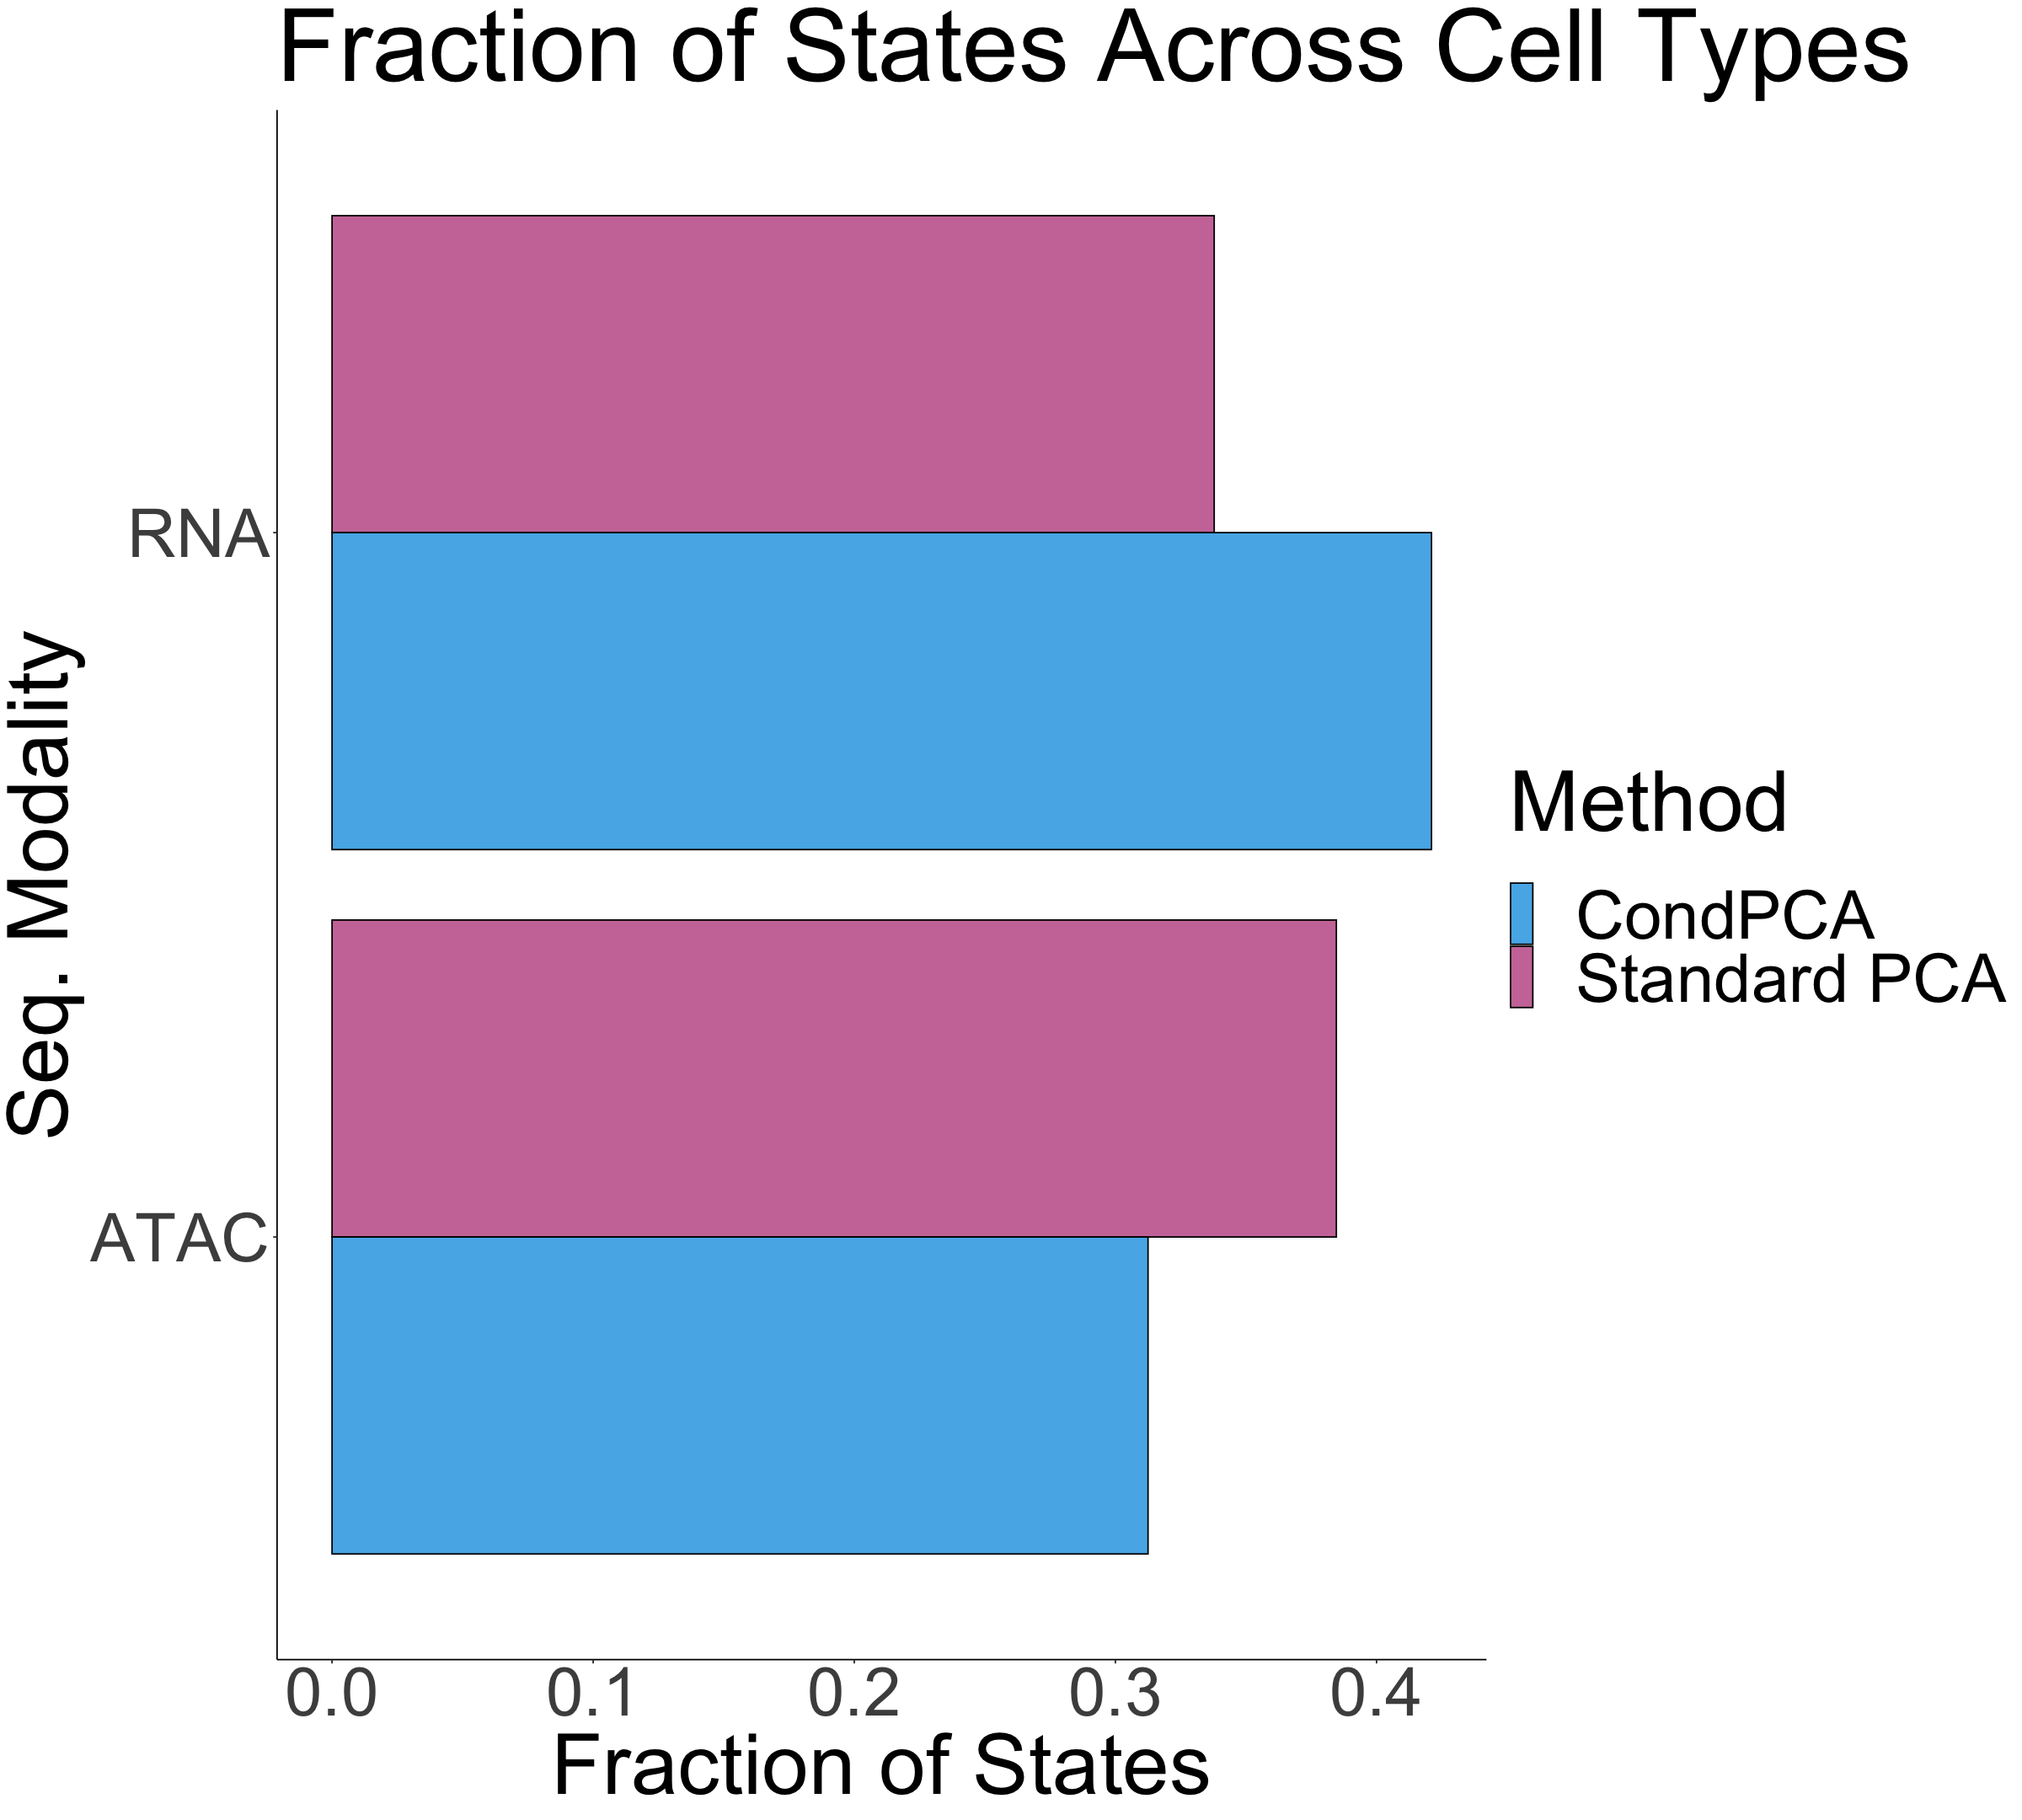

In [219]:
options(repr.plot.width=20, repr.plot.height=18)
ggplot(output, aes(fill=method, y=perc, x=data)) + 
    geom_bar(position="dodge", stat="identity",color="black") + coord_flip() + theme_classic() + ggtitle("Fraction of States Across Cell Types") + xlab("Seq. Modality") + ylab("Fraction of States")+theme(text = element_text(size=60))+labs(fill="Method")+scale_fill_manual(values=c("#56B4E9", "#CC79A7")) 

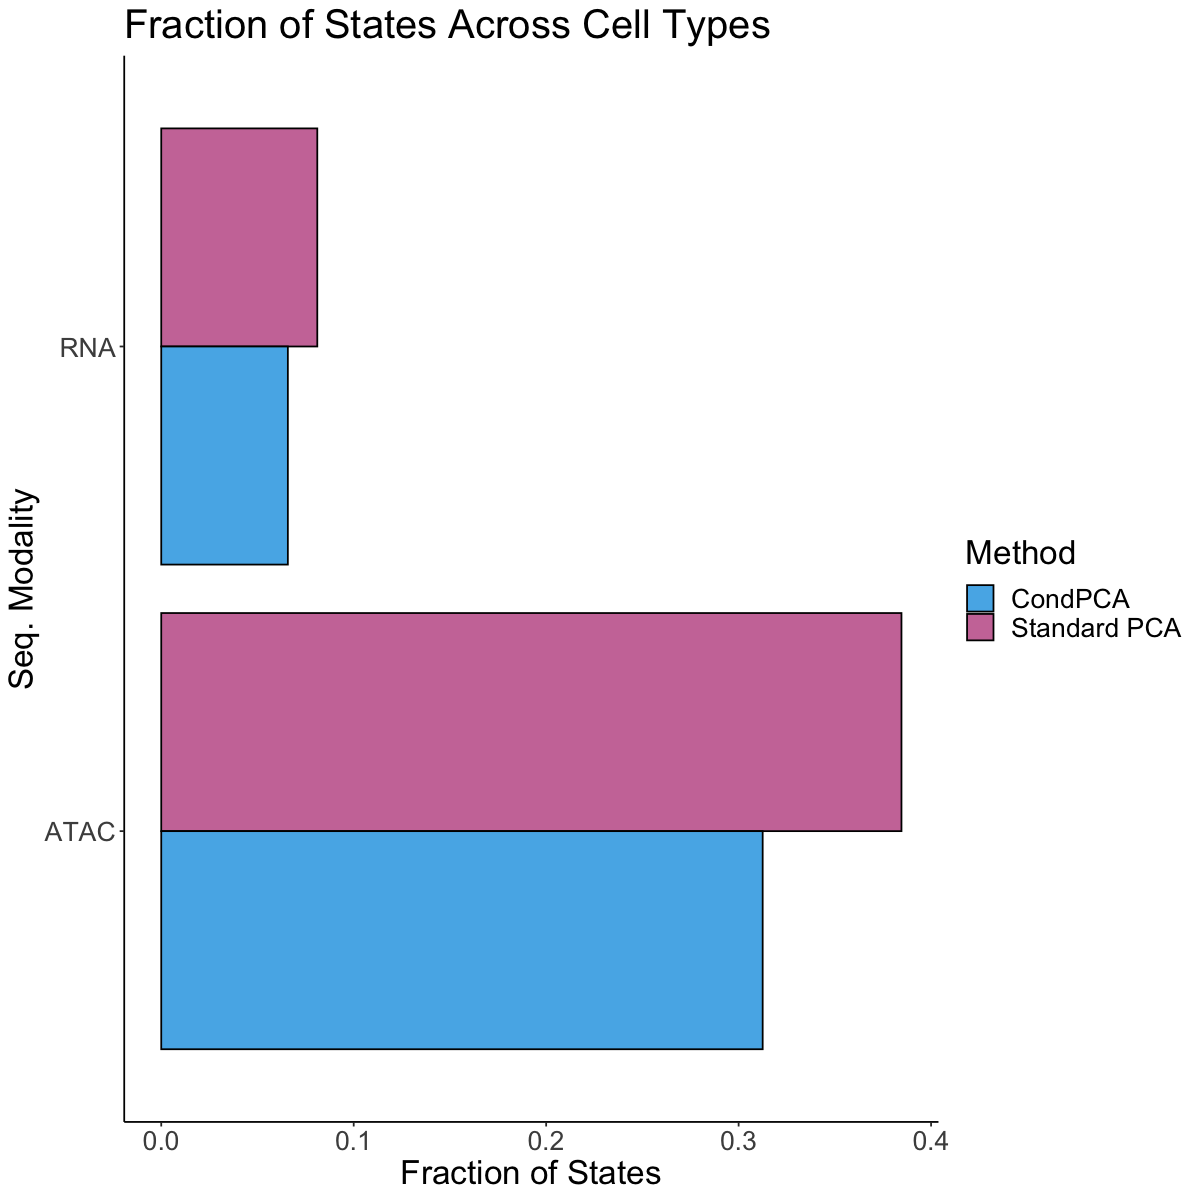

In [159]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(output, aes(fill=method, y=perc, x=data)) + 
    geom_bar(position="dodge", stat="identity",color="black") + coord_flip() + theme_classic() + ggtitle("Fraction of States Across Cell Types") + xlab("Seq. Modality") + ylab("Fraction of States")+theme(text = element_text(size=20))+labs(fill="Method")+scale_fill_manual(values=c("#56B4E9", "#CC79A7")) 

Threholding and plotting thresholds to show to Sasha

In [113]:
# alternatively, doing what sasha thought, choosing a threshold and counting states
thresholds=seq(0.05,0.99,by=.02)
options(repr.plot.width = 15, repr.plot.height = 7)

cout_based_on_thresh <- function(df2, df1, df1_name, df2_name){
    # compute intersecting genes
    mutual_genes = intersect(rownames(df1), rownames(df2) )
    # subset both dataframes
    df1_mut = df1[mutual_genes,]
    df2_mut = df2[mutual_genes,]
    # compute squared correlation
    corr_matrix = cor(df1_mut,df2_mut)**2
    # compute maximum squared correlation
    # take the max over the larger dimension to capture all of the correlations
    if (dim(corr_matrix)[1] >= dim(corr_matrix)[2]){

        max_corrs = data.frame(apply(corr_matrix,1,max) )
        
    } else if (dim(corr_matrix)[1] < dim(corr_matrix)[2]) {

        max_corrs = data.frame(apply(corr_matrix,2,max) )

    } else {
        stop("weird dimensions of correlation matrix")
    }
    colnames(max_corrs) = "sq_corr"
    
    # iterate over set of thresholds
    for (thresh in thresholds){
        max_corrs[paste0(df2_name,"_",thresh)] = FALSE
        max_corrs[paste0(df2_name,"_",thresh)] = max_corrs$sq_corr > thresh

    }

    max_corrs = subset(max_corrs, select = -c(sq_corr) )
    max_corrs$PC = rownames(max_corrs)
    # reset index
    row.names(max_corrs) <- NULL


    return(max_corrs)


    
}

In [178]:
compute_threshold_graph <- function(cons_df, cons_name){ # constand df and constant name
  dataframes <- list("ASC" = ASC, "EX" = EX, "INH"=INH, "MG"=MG, "ODC"=ODC, "OPC"=OPC,"PER.END"=PER.END )
  names <- list("ASC" = "ASC", "EX" = "EX", "INH"="INH", "MG"="MG", "ODC"="ODC", "OPC"="OPC","PER.END"="PER.END")
  # compute dataframes for each dataset signifying which PCs meet threshold
  results <- pmap(list(dataframes,cons_df, cons_name,names), cout_based_on_thresh)

  # merge all of these dataframes
  merge_by_column <- function(x, y) {
    merge(x, y, by = "PC", all = TRUE)
  }

  merged_df <- Reduce(merge_by_column, results)
  rownames(merged_df) = merged_df$PC
  # find PCs per threshold, that are all false, meaning they never show up as meeting the threshold

  for (i in 1:length(thresholds) ){

      cols_subset_to = grepl(as.character(thresholds[i]), colnames(merged_df), ignore.case = TRUE)
      tmp_df = merged_df[,cols_subset_to]

      # obtain percent of PCs that do not meet threshold
      dec_tmp = dim(tmp_df[rowSums(tmp_df) == 0, ])[1] / dim(tmp_df)[1]
      percent_per_thresh[i] = dec_tmp

  }
  # put this into a dataframe
  df = data.frame(percent_PCs_across_state=percent_per_thresh, thresholds=thresholds)
  return(df)
}


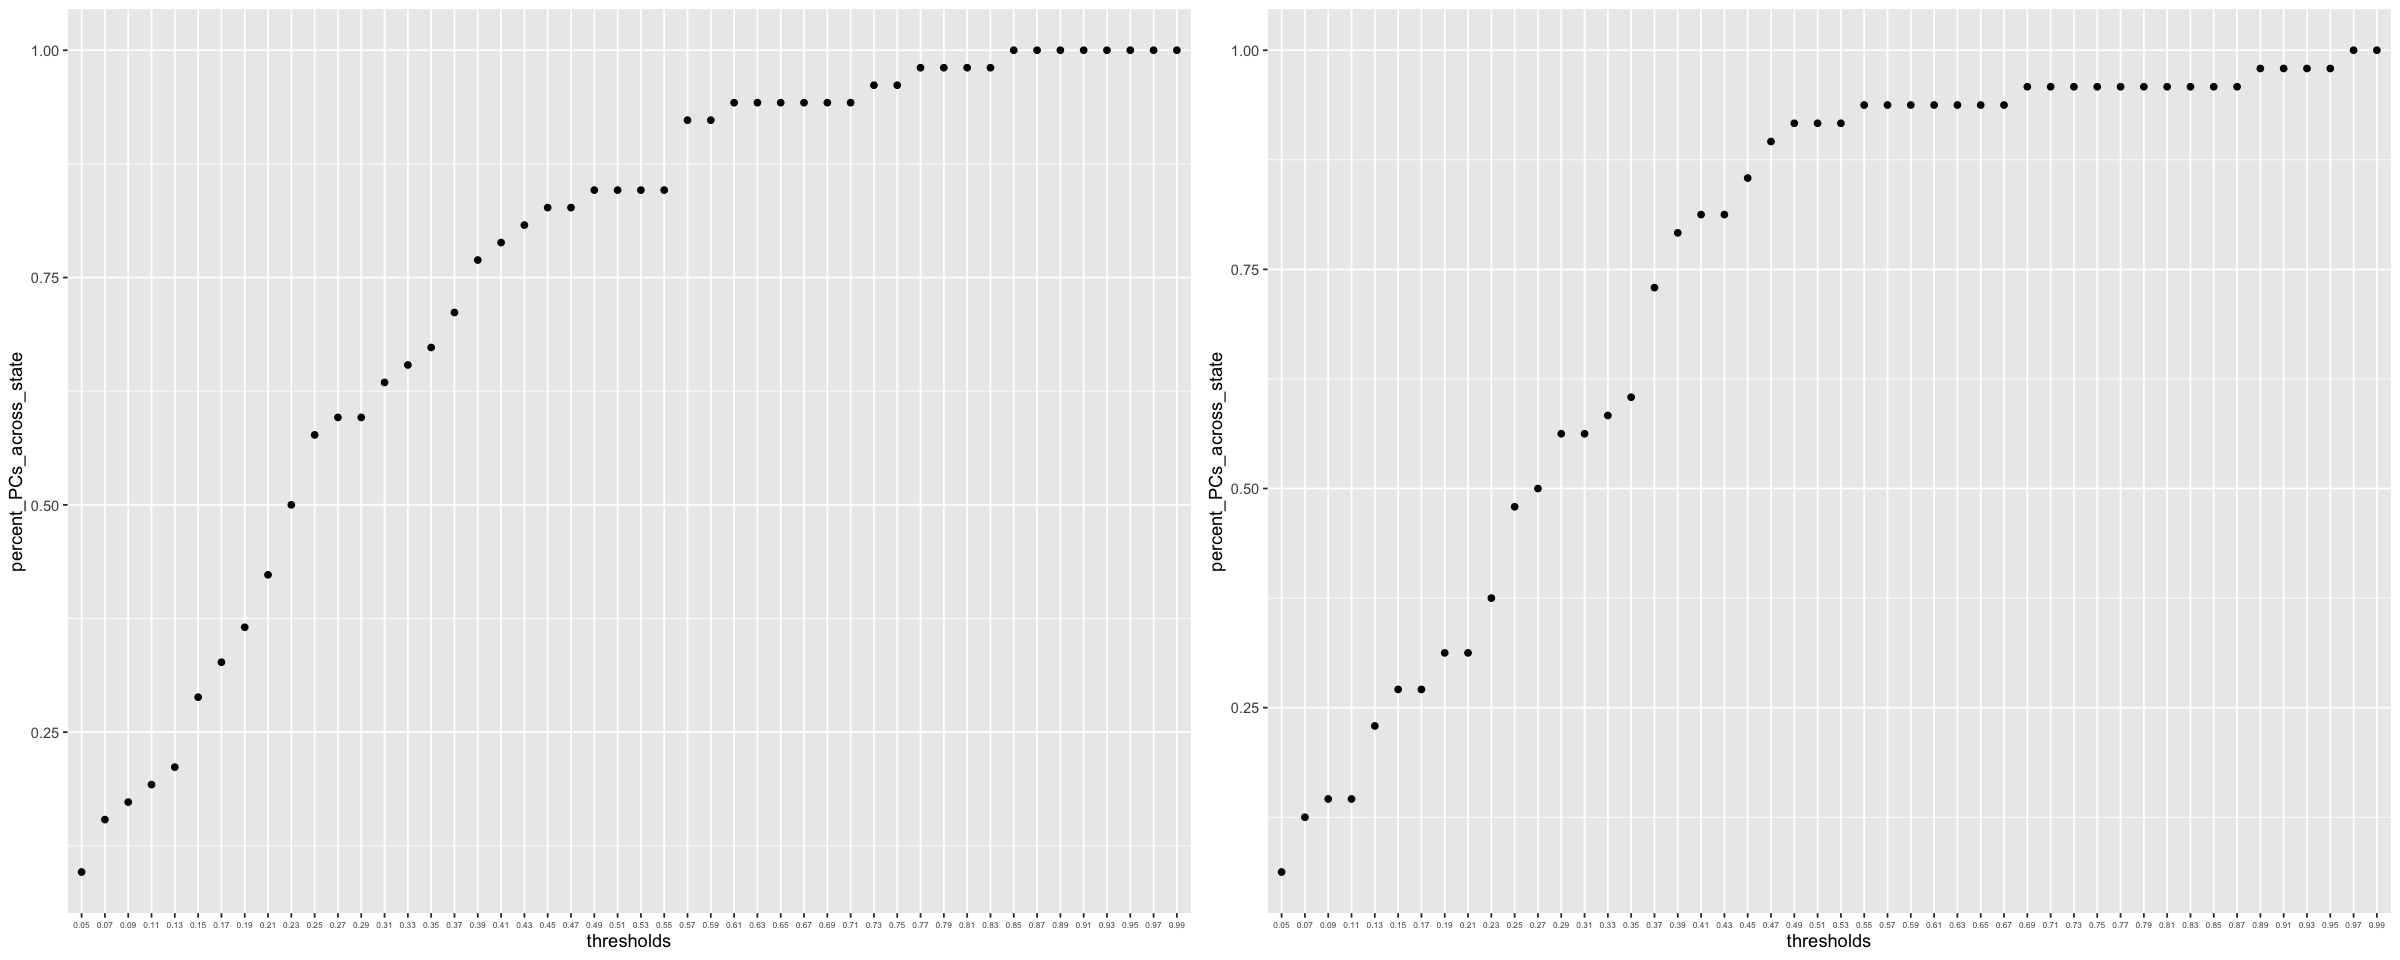

In [185]:
# ATAC
stand = read.csv("~/Downloads/ATAC/Morabito_ATAC_Standard_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_Standard_PCA"),]$BIC]
cond = read.csv("~/Downloads/ATAC/Morabito_ATAC_Conditional_Celltype_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_Conditional_PCA"),]$BIC]
ASC = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_ASC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_ASC"),]$BIC]
EX = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_EX_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_EX"),]$BIC]
INH = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_INH_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_INH"),]$BIC]
MG = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_MG_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_MG"),]$BIC]
ODC = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_ODC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_ODC"),]$BIC]
OPC = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_OPC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_OPC"),]$BIC]
PER.END = read.csv("~/Downloads/ATAC/Morabito_ATAC_Iterative_PER.END_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "ATAC_PER.END"),]$BIC]


cons_df <- list("stand"=stand)
cons_name <- list(df1_name = "ATAC Stand")

ATAC_stand = compute_threshold_graph(cons_df=cons_df, cons_name=cons_name)

cons_df <- list("cond"=cond)
cons_name <- list(df1_name = "ATAC Cond")

ATAC_cond = compute_threshold_graph(cons_df=cons_df, cons_name=cons_name)

ATAC_stand$thresholds = factor(ATAC_stand$thresholds, levels = unique(ATAC_stand$thresholds))
p1 = ggplot(ATAC_stand, aes(x = thresholds, y = percent_PCs_across_state)) +
  geom_point()+theme(
    axis.text.x = element_text(size = 5)  # Adjust the size of x-axis text
  )

ATAC_cond$thresholds = factor(ATAC_cond$thresholds, levels = unique(ATAC_cond$thresholds))
p2 = ggplot(ATAC_cond, aes(x = thresholds, y = percent_PCs_across_state)) +
  geom_point()+theme(
    axis.text.x = element_text(size = 5)  # Adjust the size of x-axis text
  )

options(repr.plot.width = 20, repr.plot.height = 8)
grid.arrange(p1, p2, ncol=2)



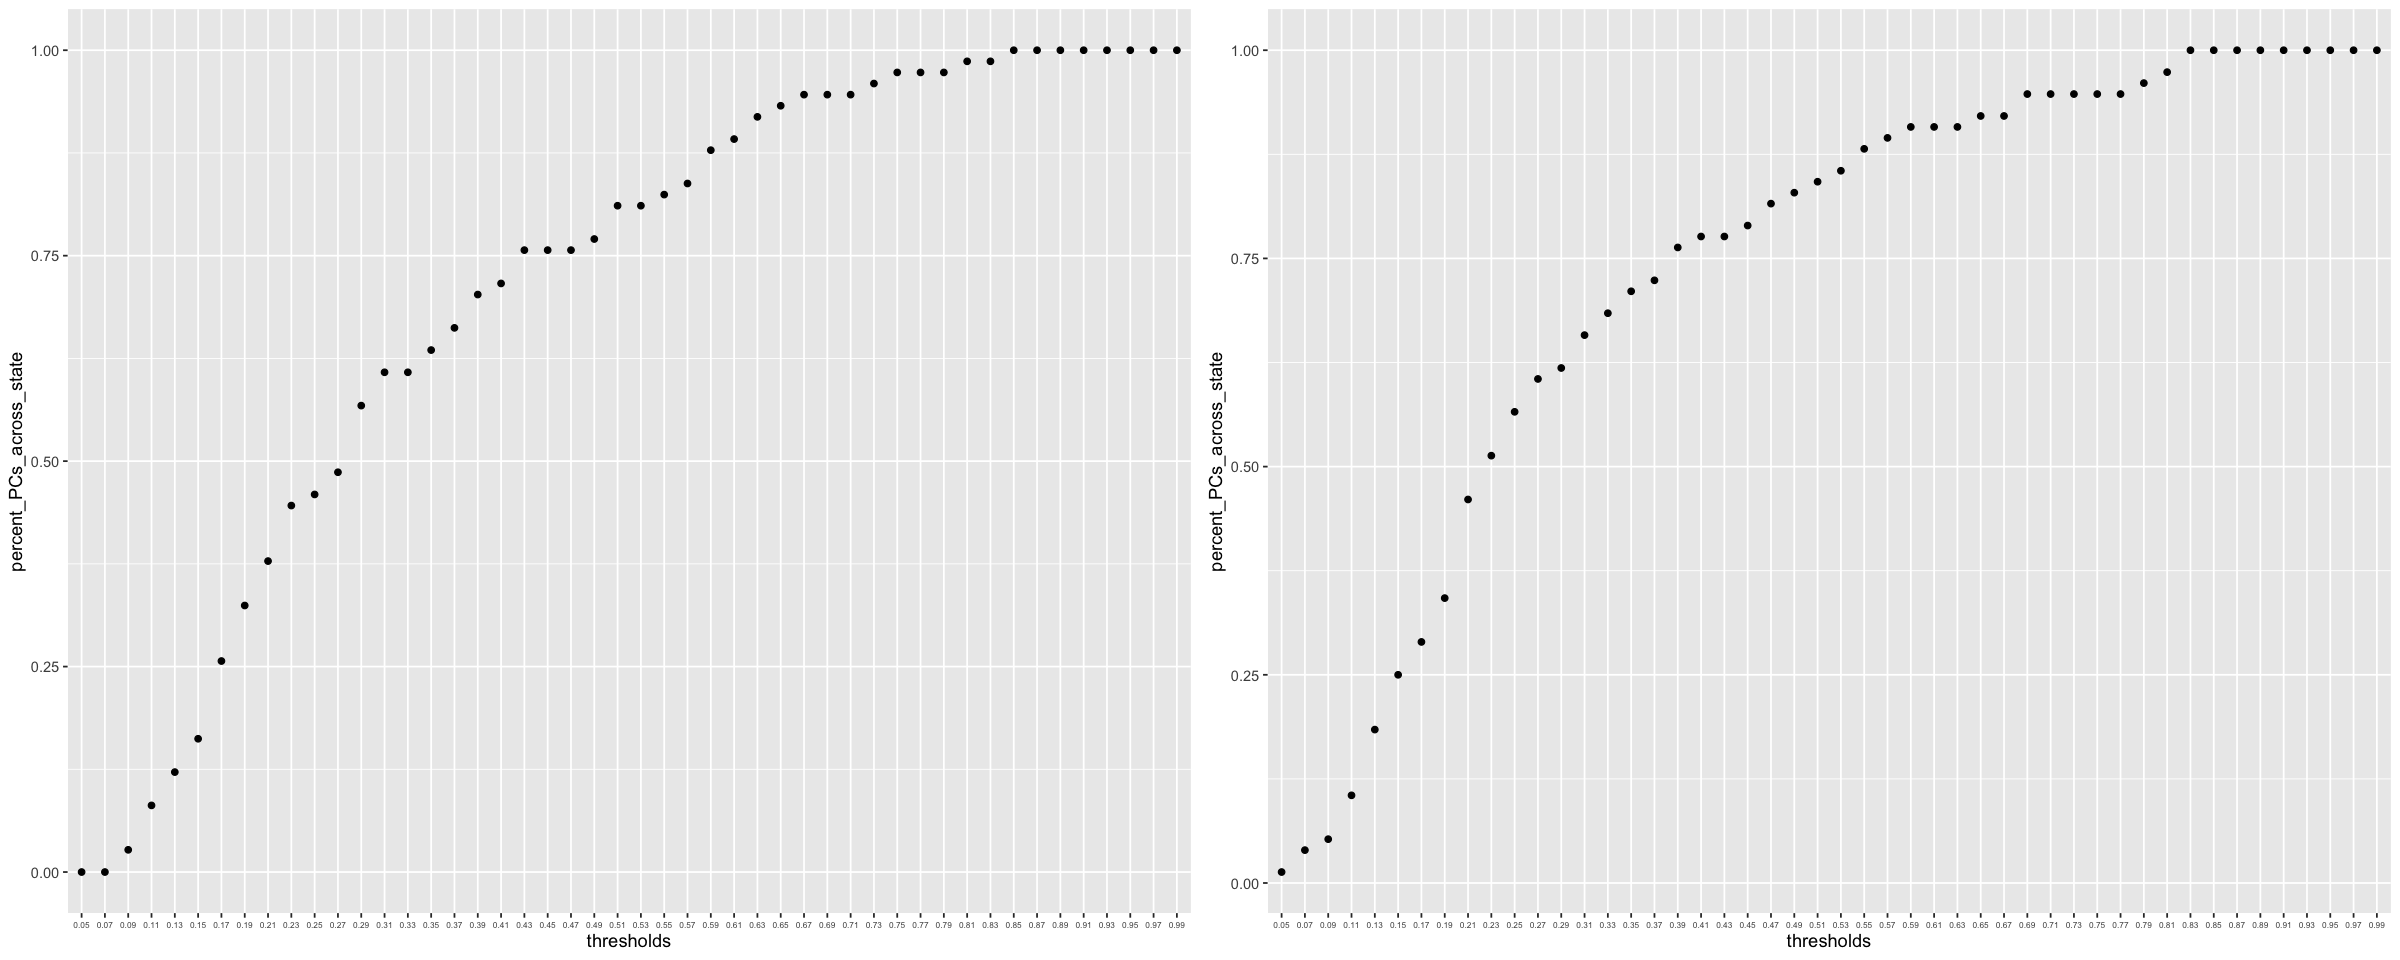

In [186]:
# RNA
stand = read.csv("~/Downloads/RNA/Morabito_RNA_Standard_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_Standard_PCA"),]$BIC]
cond = read.csv("~/Downloads/RNA/Morabito_RNA_Conditional_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_Conditional_PCA"),]$BIC]
ASC = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_ASC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_ASC"),]$BIC]
EX = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_EX_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_EX"),]$BIC]
INH = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_INH_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_INH"),]$BIC]
MG = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_MG_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_MG"),]$BIC]
ODC = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_ODC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_ODC"),]$BIC]
OPC = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_OPC_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_OPC"),]$BIC]
PER.END = read.csv("~/Downloads/RNA/Morabito_RNA_Iterative_PER.END_PCA_Loadings_3kVargenes_batch_regressed.csv", row.names=1)[,1:BIC_cuttoffs[(BIC_cuttoffs$Dataframe == "RNA_PER.END"),]$BIC]

cons_df <- list("stand"=stand)
cons_name <- list(df1_name = "RNA Stand")

RNA_stand = compute_threshold_graph(cons_df=cons_df, cons_name=cons_name)

cons_df <- list("cond"=cond)
cons_name <- list(df1_name = "RNA Cond")

RNA_cond = compute_threshold_graph(cons_df=cons_df, cons_name=cons_name)

RNA_stand$thresholds = factor(RNA_stand$thresholds, levels = unique(RNA_stand$thresholds))
p1 = ggplot(RNA_stand, aes(x = thresholds, y = percent_PCs_across_state)) +
  geom_point()+theme(
    axis.text.x = element_text(size = 5)  # Adjust the size of x-axis text
  )

RNA_cond$thresholds = factor(RNA_cond$thresholds, levels = unique(RNA_cond$thresholds))
p2 = ggplot(RNA_cond, aes(x = thresholds, y = percent_PCs_across_state)) +
  geom_point()+theme(
    axis.text.x = element_text(size = 5)  # Adjust the size of x-axis text
  )

options(repr.plot.width = 20, repr.plot.height = 8)
grid.arrange(p1, p2, ncol=2)